In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation
from tensorflow.keras import Model
from keras.datasets import mnist
from __future__ import absolute_import, division, print_function, unicode_literals
tf.keras.backend.set_floatx('float64')

LOG_DIR = "../saved_models/"
MODEL_NAME = "10_1_19_mnist_am_weights"

# Data

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Model

In [2]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.d1 = Dense(200, name='d1')
        self.r1 = Activation('relu', name = 'r1')
        self.d2 = Dense(100, name='d2')
        self.r2 = Activation('relu', name = 'r1')
        self.d3 = Dense(10, name='d3')
        self.s1 = Activation('softmax', name = 's1')

    def call(self, x):
        x = self.d1(x)
        x = self.r1(x)
        x = self.d2(x)
        x = self.r2(x)
        x = self.d3(x)
        return self.s1(x)
    
model = MyModel()

# Loss

In [3]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Train

In [4]:
# define own function
def train_step(model,images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
    
def test_step(model, images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)
    
def train(model, train_ds, test_ds, EPOCHS=1): 
    for epoch in range(EPOCHS):
        for images, labels in train_ds:
            train_step(model, images, labels)

        for test_images, test_labels in test_ds:
            test_step(model, test_images, test_labels)
        
        template = 'Epoch {}, Loss: {}, Accuracy: {}%, Test Loss: {}, Test Accuracy: {}%'
        print(template.format(epoch+1,
                            train_loss.result().numpy(),
                            train_accuracy.result().numpy()*100,
                            test_loss.result().numpy(),
                            test_accuracy.result().numpy()*100))
        
            
        
        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
            
    
def evaluate(model, test_ds):
    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels)
    loss = test_loss.result().numpy()
    accuracy = test_accuracy.result().numpy() * 100
    test_loss.reset_states()
    test_accuracy.reset_states()
    return loss, accuracy


In [103]:
## redo model with early stopping

In [14]:
train(model, train_ds, test_ds, EPOCHS = 10)
evaluate(model, test_ds)

Epoch 1, Loss: 0.06181207255562767, Accuracy: 98.02333333333333%, Test Loss: 0.07924942150341009, Test Accuracy: 97.50999999999999%
Epoch 2, Loss: 0.045913401182725404, Accuracy: 98.52166666666666%, Test Loss: 0.08767153114854191, Test Accuracy: 97.32%
Epoch 3, Loss: 0.03558102019691917, Accuracy: 98.845%, Test Loss: 0.09031742848318813, Test Accuracy: 97.50999999999999%
Epoch 4, Loss: 0.02973740924014419, Accuracy: 99.01166666666667%, Test Loss: 0.07838599271519761, Test Accuracy: 97.88%
Epoch 5, Loss: 0.023433099235231444, Accuracy: 99.195%, Test Loss: 0.10135537405561083, Test Accuracy: 97.67%
Epoch 6, Loss: 0.021281937316752736, Accuracy: 99.29833333333333%, Test Loss: 0.09171598669911019, Test Accuracy: 97.61%
Epoch 7, Loss: 0.020513185783098985, Accuracy: 99.30166666666666%, Test Loss: 0.10206649654682211, Test Accuracy: 97.81%
Epoch 8, Loss: 0.0186471260569621, Accuracy: 99.38333333333334%, Test Loss: 0.09797656592665129, Test Accuracy: 97.94%
Epoch 9, Loss: 0.013503357010968345

(0.11865089802831143, 97.52)

# Save Model

In [15]:
model.save_weights(os.path.join(LOG_DIR, MODEL_NAME))

# Load Model

In [10]:
model = MyModel()
model.load_weights(os.path.join(LOG_DIR, MODEL_NAME))
evaluate(model, test_ds) # should be around 98% accuracy

(0.11865089802831143, 97.52)

# Freeze Model

In [11]:
model.trainable=False
assert(model.trainable_weights == [])


#  AM

In [124]:
def feed_through_k_layer(model, inp, k): 
    assert(k < len(model.layers))
    x = inp
    for layer in model.layers[:k]: 
        x = layer(x)
    return x

def plot_image(tensor): 
    pixels = am_input.numpy().reshape((28, 28))
    plt.figure(figsize=(4, 4))
    plt.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

def activation_maximization_loss(predictions, target, inp, verbose=True): 
    if verbose: 
        print(predictions)
    return tf.reduce_sum(tf.math.multiply(predictions, target)) \
         - lamb * tf.cast(tf.reduce_sum(tf.square(inp)), tf.double) #regularizer or else AM doesn't work

    
#am_input = tf.Variable(tf.convert_to_tensor(x_train[0].reshape((1, 784)), dtype='double'), trainable=True)
def activation_maximization(target = 0, learning_rate = tf.constant([0.1], dtype='float64'), lamb = tf.constant([0.00001], dtype='float64'), iterations=100, verbose=False): 
    am_input = tf.Variable(tf.random.normal((1, 784)), trainable=True)
    x = [0] * 10; 
    x[target] = 1.0
    target = tf.constant(x, dtype='float64')
    k = len(model.layers) - 1
    for i in range(iterations):
        with tf.GradientTape() as tape:
            predictions = feed_through_k_layer(model, am_input, k)
            loss = activation_maximization_loss(predictions, target, am_input, verbose)
        am_gradient = tf.cast(tape.gradient(loss, am_input), tf.float64) 
        am_input.assign_add(tf.cast(learning_rate * am_gradient, tf.float32))
        am_input = tf.Variable(tf.clip_by_value(am_input, 0, 1), trainable=True)
        print(am_input)
        if verbose: 
            print("Loss: ", loss.numpy())
            plot_image(am_input)
    return am_input

tf.Tensor(
[[ -7.37745102  -8.12796572 -42.35323399 -38.19011881  -8.79209995
   -7.35954121 -15.74991193  46.79754633 -23.48337336 -10.64484242]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.6703122 , 0.13247162,
        0.        , 0.        , 0.05285983, 0.        , 0.        ,
        0.30475512, 0.        , 0.        , 0.        , 0.        ,
        0.9133828 , 0.        , 0.46523553, 0.10307597, 0.        ,
        0.        , 0.9633606 , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.3343921 , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 0.        , 1.        ,
        0.28974107, 0.7995747 , 0.87018895, 0.        , 0.60930365,
        0.59630984, 0.7217356 , 0.94559103, 1.        , 0.        ,
        0.7

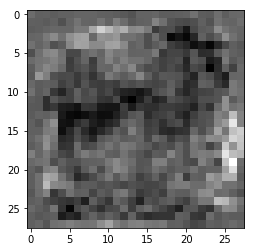

tf.Tensor(
[[  6.57379312  -7.13378324  -9.08323551 -12.88778472 -14.23687885
    0.82856089   8.84954594   0.90785695  -5.5155871   -7.90688823]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.93241693e-04, 5.86337585e-04, 1.33978378e-04, 6.70028567e-01,
        1.33251354e-01, 8.75014375e-05, 0.00000000e+00, 5.29171489e-02,
        4.68118960e-04, 0.00000000e+00, 3.04774255e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.69535098e-03, 9.13751006e-01,
        9.32604089e-05, 4.65895146e-01, 1.03763729e-01, 0.00000000e+00,
        3.61836319e-05, 9.63256180e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 4.96727371e-05, 0.00000000e+00, 0.00000000e+00,
        2.32751830e-04, 9.98865604e-01, 3.34622145e-01, 2.21860944e-04,
        9.99742568e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.95873153e-01, 0.00000000e+00, 0.00000000e+00,
        9.93747830e-01, 9.94169116e-01,

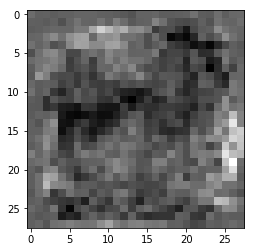

tf.Tensor(
[[  6.7237904   -6.8609975   -8.98795482 -12.4212055  -13.65260001
    0.68628675   8.23882892   1.06103678  -5.55264001  -7.31571908]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.46847693e-04, 1.43563235e-03, 2.55404128e-04, 6.69762611e-01,
        1.34159550e-01, 2.68011179e-04, 0.00000000e+00, 5.31783812e-02,
        9.13862255e-04, 0.00000000e+00, 3.04987729e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.63914552e-03, 9.14158225e-01,
        4.11685876e-04, 4.66475844e-01, 1.04399346e-01, 0.00000000e+00,
        0.00000000e+00, 9.63064253e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.90859214e-04, 9.97697830e-01, 3.34673285e-01, 4.31869703e-04,
        9.99252021e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.91353273e-01, 0.00000000e+00, 0.00000000e+00,
        9.87212181e-01, 9.88232434e-01,

Loss:  [-9.33107247]


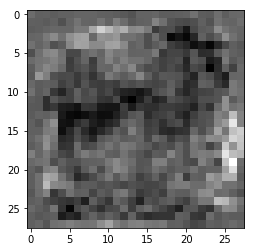

tf.Tensor(
[[  7.02523103  -6.77273198  -8.84717509 -12.06362582 -13.04209347
    0.50398418   7.53051721   1.14480536  -5.56407962  -6.50350513]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.94706323e-04, 2.53560068e-03, 3.79444100e-04, 6.69350624e-01,
        1.35611922e-01, 3.57849145e-04, 0.00000000e+00, 5.36600649e-02,
        1.53171015e-03, 0.00000000e+00, 3.05511564e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.00422360e-03, 9.14742231e-01,
        1.12499192e-03, 4.67317104e-01, 1.05074592e-01, 0.00000000e+00,
        0.00000000e+00, 9.63153481e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.81167541e-04, 9.96476889e-01, 3.34544063e-01, 6.45951310e-04,
        9.98627782e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.86010194e-01, 0.00000000e+00, 0.00000000e+00,
        9.79464531e-01, 9.81694937e-01,

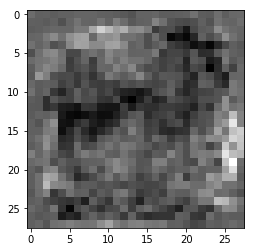

tf.Tensor(
[[  7.52869191  -6.84686277  -8.7466733  -11.78703787 -12.34481751
    0.26631077   6.62259004   1.25813103  -5.54255347  -5.39583984]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[4.42555407e-04, 3.63534922e-03, 5.03459247e-04, 6.68938696e-01,
        1.37063995e-01, 4.47669154e-04, 0.00000000e+00, 5.41416518e-02,
        2.14943429e-03, 0.00000000e+00, 3.06035280e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 8.36882833e-03, 9.15326118e-01,
        1.83815532e-03, 4.68158215e-01, 1.05749704e-01, 0.00000000e+00,
        0.00000000e+00, 9.63242650e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.37139787e-03, 9.95256186e-01, 3.34414840e-01, 8.59990134e-04,
        9.98003662e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.80668187e-01, 0.00000000e+00, 0.00000000e+00,
        9.71718431e-01, 9.75158751e-01,

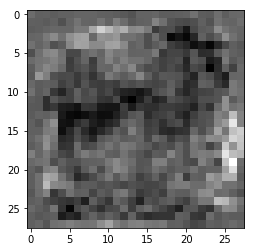

tf.Tensor(
[[  8.06374871  -6.87108199  -8.71809347 -11.65441658 -11.67088249
   -0.01309582   5.59655931   1.35880757  -5.4633531   -4.25280056]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[6.86712447e-04, 4.45111562e-03, 3.08213726e-04, 6.68641269e-01,
        1.38431445e-01, 3.30527342e-04, 0.00000000e+00, 5.45602702e-02,
        2.72671366e-03, 0.00000000e+00, 3.06474596e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.04198130e-02, 9.15932715e-01,
        2.57490994e-03, 4.69134778e-01, 1.06428109e-01, 0.00000000e+00,
        0.00000000e+00, 9.63234484e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.83358893e-03, 9.93941963e-01, 3.34355086e-01, 1.36454753e-03,
        9.97361720e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.75580513e-01, 0.00000000e+00, 0.00000000e+00,
        9.63994622e-01, 9.68608797e-01,

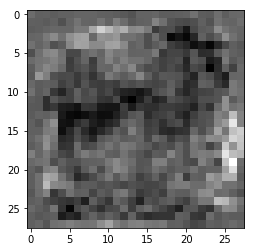

tf.Tensor(
[[  8.46778648  -6.840632    -8.57691436 -11.62366947 -11.03004788
   -0.34191071   4.7415003    1.44307519  -5.34678327  -3.33769975]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.98164396e-03, 4.49092127e-03, 3.35934601e-04, 6.68383002e-01,
        1.39819264e-01, 6.34741387e-04, 0.00000000e+00, 5.49546331e-02,
        2.45324848e-03, 0.00000000e+00, 3.06358337e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.19838100e-02, 9.16015804e-01,
        3.20200156e-03, 4.69971061e-01, 1.07192308e-01, 0.00000000e+00,
        0.00000000e+00, 9.64116573e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.25242577e-04, 3.48619156e-04,
        2.30552792e-03, 9.92862105e-01, 3.34253907e-01, 1.78101554e-03,
        9.97462809e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.70667243e-01, 0.00000000e+00, 0.00000000e+00,
        9.58055854e-01, 9.61477995e-01,

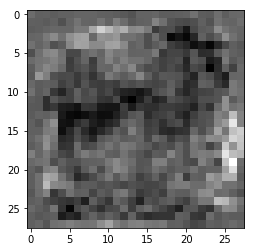

tf.Tensor(
[[  8.76880551  -6.6694041   -8.25091691 -11.47243305 -10.5724187
   -0.6570401    4.16052626   1.43814395  -5.32754945  -2.74354078]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.73733260e-03, 4.95468779e-03, 5.20731846e-05, 6.68011069e-01,
        1.40722468e-01, 1.58103928e-03, 0.00000000e+00, 5.58100492e-02,
        2.85030808e-03, 4.24028025e-04, 3.06810826e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.39516667e-02, 9.15991604e-01,
        4.01229039e-03, 4.70565915e-01, 1.08392619e-01, 0.00000000e+00,
        0.00000000e+00, 9.64646816e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.50212455e-04, 1.19261188e-03,
        2.94656912e-03, 9.92110729e-01, 3.33952278e-01, 1.93796260e-03,
        9.97162342e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.66375470e-01, 0.00000000e+00, 0.00000000e+00,
        9.52910781e-01, 9.55983162e-01, 

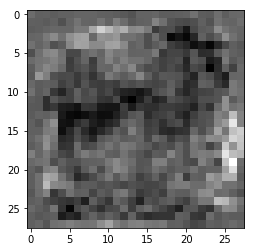

tf.Tensor(
[[  9.13337754  -6.52735068  -7.97957789 -11.38114029 -10.21116258
   -0.94286203   3.62807385   1.41799277  -5.33934381  -2.18428297]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.73728503e-03, 5.38416533e-03, 2.81386019e-06, 6.67297125e-01,
        1.41320691e-01, 2.76059471e-03, 0.00000000e+00, 5.69924712e-02,
        2.93749059e-03, 9.93613619e-04, 3.07592601e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.56651605e-02, 9.15679157e-01,
        4.87906672e-03, 4.70910668e-01, 1.09898798e-01, 0.00000000e+00,
        0.00000000e+00, 9.65343475e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 9.90748638e-04, 1.71600957e-03,
        3.69227771e-03, 9.91611838e-01, 3.33664566e-01, 2.40998250e-03,
        9.96858954e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.61686850e-01, 0.00000000e+00, 0.00000000e+00,
        9.47227001e-01, 9.50204670e-01,

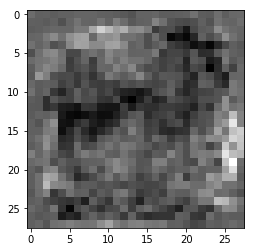

tf.Tensor(
[[  9.56365014  -6.39856887  -7.76021684 -11.38346795  -9.84984127
   -1.2491611    3.04339231   1.4293464   -5.39799234  -1.58267383]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[4.81720222e-03, 5.82952471e-03, 0.00000000e+00, 6.66600704e-01,
        1.41941562e-01, 3.94679885e-03, 0.00000000e+00, 5.81732616e-02,
        3.10732424e-03, 1.61785050e-03, 3.08441997e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.74716264e-02, 9.15365577e-01,
        5.78419073e-03, 4.71200883e-01, 1.11439183e-01, 0.00000000e+00,
        0.00000000e+00, 9.66092229e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.49683550e-03, 2.17501563e-03,
        4.37655021e-03, 9.91134942e-01, 3.33355248e-01, 2.89364276e-03,
        9.96564507e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.56786335e-01, 0.00000000e+00, 0.00000000e+00,
        9.41345334e-01, 9.44329679e-01,

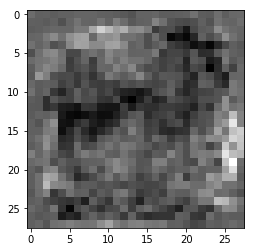

tf.Tensor(
[[  9.98104004  -6.27646714  -7.54178958 -11.3777706   -9.49518333
   -1.53412818   2.42977764   1.44483652  -5.44341074  -0.97254127]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[5.30317891e-03, 6.95480313e-03, 0.00000000e+00, 6.65896833e-01,
        1.42967612e-01, 4.58743470e-03, 0.00000000e+00, 5.97177334e-02,
        3.84007674e-03, 1.78786577e-03, 3.09833169e-01, 0.00000000e+00,
        4.17362491e-04, 0.00000000e+00, 1.95969008e-02, 9.15440202e-01,
        7.28355302e-03, 4.71340597e-01, 1.12736061e-01, 0.00000000e+00,
        0.00000000e+00, 9.66132939e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.39266578e-03, 2.14123097e-03,
        5.33856638e-03, 9.90385115e-01, 3.32892507e-01, 3.62615800e-03,
        9.95860994e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.52286959e-01, 0.00000000e+00, 0.00000000e+00,
        9.35111046e-01, 9.39294577e-01,

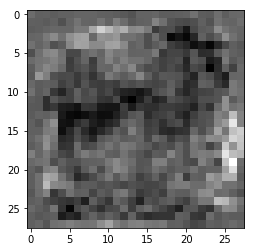

tf.Tensor(
[[ 10.35280178  -6.17752842  -7.36029447 -11.44307337  -9.13875287
   -1.81226053   1.90230013   1.46410981  -5.45385228  -0.4328446 ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[6.51335670e-03, 7.41179427e-03, 0.00000000e+00, 6.65001392e-01,
        1.43301442e-01, 5.75343240e-03, 0.00000000e+00, 6.09931089e-02,
        4.16852720e-03, 2.48129899e-03, 3.10502946e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.08062902e-02, 9.14654136e-01,
        8.21759738e-03, 4.72110629e-01, 1.14242002e-01, 0.00000000e+00,
        0.00000000e+00, 9.66799080e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.46981631e-03, 2.49131233e-03,
        6.15343545e-03, 9.89718914e-01, 3.32414091e-01, 4.31108102e-03,
        9.95301664e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.48039114e-01, 0.00000000e+00, 0.00000000e+00,
        9.30747628e-01, 9.34070170e-01,

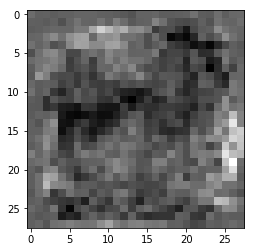

tf.Tensor(
[[ 10.60589209  -6.10817416  -7.15968867 -11.4849285   -8.82562155
   -2.05786055   1.57473322   1.41439715  -5.39985094  -0.05657626]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[7.19289435e-03, 7.68374186e-03, 3.99130426e-04, 6.64187670e-01,
        1.43582329e-01, 6.69999141e-03, 0.00000000e+00, 6.14995025e-02,
        3.98309203e-03, 2.96426285e-03, 3.11478496e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.13099997e-02, 9.14024234e-01,
        8.90981685e-03, 4.72008079e-01, 1.15007140e-01, 0.00000000e+00,
        0.00000000e+00, 9.66924310e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.07546074e-03, 3.18576652e-03,
        6.85082097e-03, 9.89587903e-01, 3.31713289e-01, 4.66976920e-03,
        9.95189071e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.44628894e-01, 0.00000000e+00, 0.00000000e+00,
        9.26486135e-01, 9.29745555e-01,

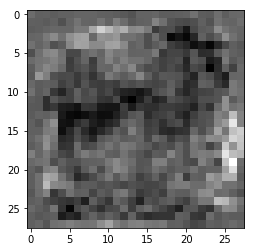

tf.Tensor(
[[ 10.91202119  -5.97267034  -6.96546517 -11.6227539   -8.52689323
   -2.3260107    1.24403752   1.35700788  -5.39128418   0.25651718]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[8.68526567e-03, 7.82972760e-03, 0.00000000e+00, 6.63153946e-01,
        1.43610418e-01, 7.19618471e-03, 0.00000000e+00, 6.28079176e-02,
        4.45294520e-03, 4.05544089e-03, 3.11855018e-01, 0.00000000e+00,
        0.00000000e+00, 1.86812598e-04, 2.20593996e-02, 9.13042247e-01,
        9.55783390e-03, 4.72972333e-01, 1.16587758e-01, 0.00000000e+00,
        0.00000000e+00, 9.67973769e-01, 0.00000000e+00, 1.00000000e+00,
        3.78343830e-04, 0.00000000e+00, 2.20193621e-03, 2.95111421e-03,
        7.40064401e-03, 9.89077091e-01, 3.31181347e-01, 5.48400637e-03,
        9.94692147e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.41070437e-01, 0.00000000e+00, 0.00000000e+00,
        9.22688305e-01, 9.24985886e-01,

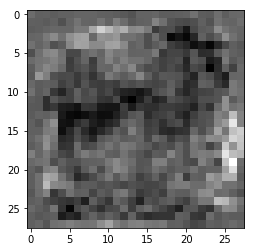

tf.Tensor(
[[ 11.05169036  -5.88947516  -6.83368348 -11.6966908   -8.22443874
   -2.51104259   0.94178901   1.35566747  -5.29525166   0.54095907]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[9.53956787e-03, 7.79955555e-03, 2.08920010e-05, 6.62214816e-01,
        1.43592730e-01, 7.73192942e-03, 0.00000000e+00, 6.35439977e-02,
        4.51497361e-03, 4.93295956e-03, 3.12519789e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.22671889e-02, 9.12302434e-01,
        1.00790588e-02, 4.73124534e-01, 1.17523044e-01, 1.94126405e-04,
        0.00000000e+00, 9.68499124e-01, 0.00000000e+00, 1.00000000e+00,
        1.92660344e-04, 0.00000000e+00, 2.84414296e-03, 3.24976817e-03,
        7.91210029e-03, 9.88864005e-01, 3.30369443e-01, 5.97507507e-03,
        9.94692802e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.38004136e-01, 0.00000000e+00, 0.00000000e+00,
        9.18623388e-01, 9.20931339e-01,

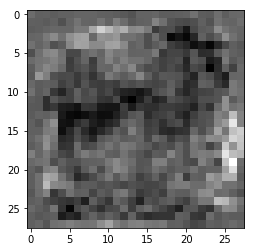

tf.Tensor(
[[ 11.29875588  -5.80819342  -6.65736127 -11.84113851  -7.98214635
   -2.74907286   0.63545401   1.34896765  -5.25046205   0.76290636]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.04465950e-02, 7.67269032e-03, 0.00000000e+00, 6.61111951e-01,
        1.44032657e-01, 8.01819004e-03, 0.00000000e+00, 6.47028089e-02,
        5.00962976e-03, 5.51408483e-03, 3.12716246e-01, 0.00000000e+00,
        2.09517311e-04, 6.38004916e-04, 2.27074027e-02, 9.11793649e-01,
        1.06154168e-02, 4.73752141e-01, 1.18887231e-01, 0.00000000e+00,
        0.00000000e+00, 9.69275653e-01, 0.00000000e+00, 1.00000000e+00,
        9.02530388e-04, 0.00000000e+00, 2.62006954e-03, 2.41060439e-03,
        7.93097820e-03, 9.88318622e-01, 3.30395103e-01, 7.04337517e-03,
        9.94100690e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.35980797e-01, 0.00000000e+00, 0.00000000e+00,
        9.16483223e-01, 9.17591155e-01,

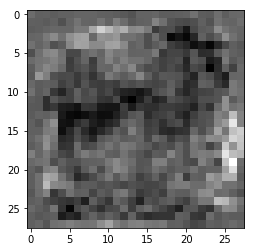

tf.Tensor(
[[ 11.32741422  -5.84833419  -6.67761981 -11.90856354  -7.85818745
   -2.78579376   0.50585787   1.4376423   -5.23403995   0.916198  ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.07553592e-02, 7.29222689e-03, 0.00000000e+00, 6.60075307e-01,
        1.44530326e-01, 8.39836337e-03, 1.05553285e-04, 6.55821860e-02,
        5.14702732e-03, 5.89143625e-03, 3.13256502e-01, 2.12444516e-04,
        0.00000000e+00, 6.01961568e-04, 2.23642830e-02, 9.11284626e-01,
        1.10900747e-02, 4.73799497e-01, 1.19842090e-01, 0.00000000e+00,
        0.00000000e+00, 9.69633281e-01, 0.00000000e+00, 1.00000000e+00,
        1.19478896e-03, 0.00000000e+00, 2.85443966e-03, 2.18964973e-03,
        8.05665366e-03, 9.88100708e-01, 3.30057740e-01, 7.94102158e-03,
        9.93833482e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.34543967e-01, 0.00000000e+00, 0.00000000e+00,
        9.14284468e-01, 9.14801657e-01,

Loss:  [-1.04192929]


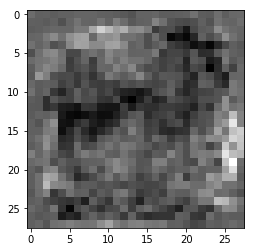

tf.Tensor(
[[ 11.43357224  -5.8842025   -6.68773101 -12.09543216  -7.7107904
   -2.88785728   0.34558223   1.53039595  -5.27661652   1.09240907]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.12153664e-02, 6.55832794e-03, 0.00000000e+00, 6.58720553e-01,
        1.45045444e-01, 8.35918821e-03, 4.41120937e-05, 6.62670806e-02,
        5.27312420e-03, 6.39276998e-03, 3.13986242e-01, 4.19626856e-04,
        0.00000000e+00, 8.51799152e-04, 2.20740624e-02, 9.11106884e-01,
        1.18754543e-02, 4.73906875e-01, 1.21182486e-01, 0.00000000e+00,
        0.00000000e+00, 9.69957471e-01, 0.00000000e+00, 1.00000000e+00,
        1.91003131e-03, 0.00000000e+00, 3.16232117e-03, 2.30876775e-03,
        8.16003792e-03, 9.87465501e-01, 3.29690188e-01, 8.87657609e-03,
        9.93902862e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.32989419e-01, 0.00000000e+00, 0.00000000e+00,
        9.11824048e-01, 9.11862195e-01, 

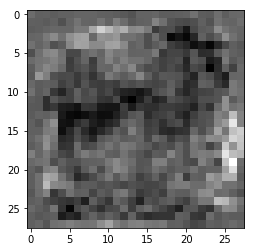

tf.Tensor(
[[ 11.45434285  -5.95349007  -6.698012   -12.24741846  -7.52566156
   -2.94996036   0.14692704   1.64870299  -5.27518275   1.30939292]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.17924726e-02, 5.99322421e-03, 0.00000000e+00, 6.57487988e-01,
        1.45633221e-01, 8.38196557e-03, 0.00000000e+00, 6.71244040e-02,
        5.45214117e-03, 7.01707881e-03, 3.14742655e-01, 6.63492829e-04,
        0.00000000e+00, 1.00239110e-03, 2.19625197e-02, 9.10939395e-01,
        1.25786504e-02, 4.73906696e-01, 1.22407205e-01, 0.00000000e+00,
        0.00000000e+00, 9.70441461e-01, 0.00000000e+00, 1.00000000e+00,
        2.58609140e-03, 0.00000000e+00, 3.46439402e-03, 2.51318188e-03,
        8.18005204e-03, 9.86840606e-01, 3.29157501e-01, 9.70720500e-03,
        9.93952990e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.31443930e-01, 0.00000000e+00, 0.00000000e+00,
        9.09447789e-01, 9.09132540e-01,

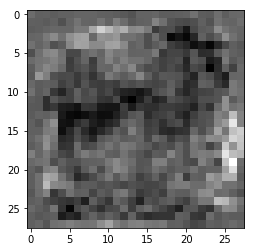

tf.Tensor(
[[ 11.48351105  -6.02546126  -6.69899467 -12.39997428  -7.35357509
   -3.01763294  -0.05013736   1.74676814  -5.27432945   1.51762   ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.29225561e-02, 5.61412051e-03, 0.00000000e+00, 6.56021535e-01,
        1.46343231e-01, 8.33544787e-03, 0.00000000e+00, 6.86179623e-02,
        6.06542546e-03, 7.76793715e-03, 3.15077037e-01, 9.61020123e-05,
        0.00000000e+00, 1.74724264e-03, 2.25139875e-02, 9.10703301e-01,
        1.35854091e-02, 4.74770546e-01, 1.24381877e-01, 0.00000000e+00,
        0.00000000e+00, 9.71513212e-01, 0.00000000e+00, 1.00000000e+00,
        3.79893510e-03, 0.00000000e+00, 3.21748271e-03, 2.33555236e-03,
        8.27382598e-03, 9.85764384e-01, 3.28902990e-01, 1.09987408e-02,
        9.93583500e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.29244637e-01, 0.00000000e+00, 0.00000000e+00,
        9.07227457e-01, 9.05513048e-01,

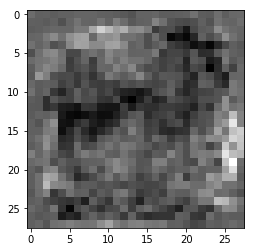

tf.Tensor(
[[ 11.4277923   -6.11831446  -6.68963972 -12.4362653   -7.18839045
   -3.05385623  -0.23859752   1.83386274  -5.21856667   1.72501484]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.33503526e-02, 4.99063777e-03, 0.00000000e+00, 6.54675007e-01,
        1.46992490e-01, 8.13296530e-03, 0.00000000e+00, 6.97114915e-02,
        6.15843944e-03, 8.35153181e-03, 3.15973282e-01, 4.40164993e-04,
        0.00000000e+00, 1.85202982e-03, 2.23032776e-02, 9.11054671e-01,
        1.44194383e-02, 4.74834889e-01, 1.25875458e-01, 0.00000000e+00,
        0.00000000e+00, 9.71915364e-01, 0.00000000e+00, 1.00000000e+00,
        4.35376912e-03, 0.00000000e+00, 3.53859481e-03, 2.71080690e-03,
        8.39303341e-03, 9.85058248e-01, 3.28261673e-01, 1.20963864e-02,
        9.93586481e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.27229762e-01, 0.00000000e+00, 0.00000000e+00,
        9.04587448e-01, 9.02631044e-01,

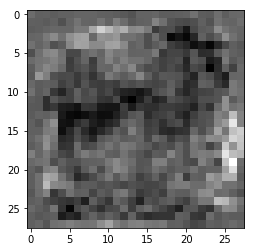

tf.Tensor(
[[ 11.40929314  -6.2333679   -6.65121571 -12.54953072  -6.98036179
   -3.11691135  -0.51143267   1.92553286  -5.1475213    1.99865154]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.37780635e-02, 4.36727982e-03, 0.00000000e+00, 6.53328776e-01,
        1.47641629e-01, 7.93052278e-03, 0.00000000e+00, 7.08048046e-02,
        6.25143480e-03, 8.93501006e-03, 3.16869348e-01, 7.84159172e-04,
        0.00000000e+00, 1.95679604e-03, 2.20926087e-02, 9.11405981e-01,
        1.52533008e-02, 4.74899232e-01, 1.27368733e-01, 0.00000000e+00,
        0.00000000e+00, 9.72317457e-01, 0.00000000e+00, 1.00000000e+00,
        4.90849232e-03, 0.00000000e+00, 3.85964266e-03, 3.08598625e-03,
        8.51221755e-03, 9.84352231e-01, 3.27620476e-01, 1.31938122e-02,
        9.93589461e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.25215244e-01, 0.00000000e+00, 0.00000000e+00,
        9.01947975e-01, 8.99749637e-01,

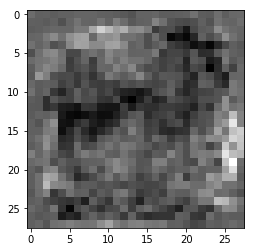

tf.Tensor(
[[ 11.39166923  -6.34915315  -6.6101008  -12.65461306  -6.7829417
   -3.17559312  -0.77539197   2.01221569  -5.07841515   2.26700743]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.41944000e-02, 3.78302811e-03, 0.00000000e+00, 6.52040124e-01,
        1.48242787e-01, 7.74748717e-03, 0.00000000e+00, 7.19556287e-02,
        6.27480820e-03, 9.44950432e-03, 3.17809850e-01, 1.10234995e-03,
        0.00000000e+00, 2.05698982e-03, 2.18773223e-02, 9.11764026e-01,
        1.60626359e-02, 4.74999726e-01, 1.28832042e-01, 0.00000000e+00,
        0.00000000e+00, 9.72666383e-01, 0.00000000e+00, 1.00000000e+00,
        5.45097841e-03, 0.00000000e+00, 4.15269379e-03, 3.51660745e-03,
        8.68632086e-03, 9.83672857e-01, 3.26953024e-01, 1.42883956e-02,
        9.93556142e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.23224509e-01, 0.00000000e+00, 0.00000000e+00,
        8.99534702e-01, 8.97043526e-01, 

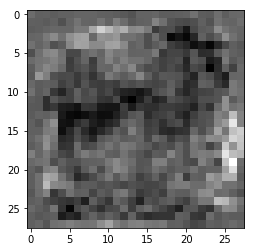

tf.Tensor(
[[ 11.35951372  -6.46943759  -6.56037773 -12.75685835  -6.59098389
   -3.23675574  -1.03668736   2.09782655  -5.01209952   2.53696874]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.47183696e-02, 3.10181384e-03, 0.00000000e+00, 6.50729775e-01,
        1.48798272e-01, 7.60282297e-03, 0.00000000e+00, 7.32046440e-02,
        6.26122765e-03, 1.00567993e-02, 3.18784624e-01, 1.48388580e-03,
        0.00000000e+00, 2.18088459e-03, 2.15719640e-02, 9.12145853e-01,
        1.69109385e-02, 4.75123852e-01, 1.30393490e-01, 0.00000000e+00,
        0.00000000e+00, 9.72985566e-01, 0.00000000e+00, 1.00000000e+00,
        6.11984031e-03, 0.00000000e+00, 4.49218601e-03, 3.91414855e-03,
        8.95749684e-03, 9.83018935e-01, 3.26246649e-01, 1.54875880e-02,
        9.93521631e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.21154439e-01, 0.00000000e+00, 0.00000000e+00,
        8.96990180e-01, 8.94151747e-01,

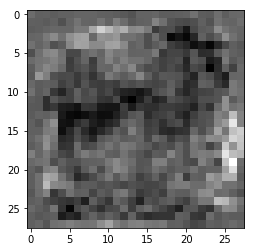

tf.Tensor(
[[ 11.31380192  -6.59102627  -6.4967591  -12.87809008  -6.37744524
   -3.33273493  -1.32814474   2.19791494  -4.94627785   2.82741303]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.52422339e-02, 2.42073601e-03, 0.00000000e+00, 6.49419665e-01,
        1.49353638e-01, 7.45818764e-03, 0.00000000e+00, 7.44534060e-02,
        6.24764990e-03, 1.06639722e-02, 3.19759190e-01, 1.86534529e-03,
        0.00000000e+00, 2.30475469e-03, 2.12666653e-02, 9.12527621e-01,
        1.77590717e-02, 4.75247949e-01, 1.31954625e-01, 0.00000000e+00,
        0.00000000e+00, 9.73304689e-01, 0.00000000e+00, 1.00000000e+00,
        6.78856857e-03, 0.00000000e+00, 4.83161071e-03, 4.31161001e-03,
        9.22861788e-03, 9.82365131e-01, 3.25540423e-01, 1.66865401e-02,
        9.93487179e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.19084787e-01, 0.00000000e+00, 0.00000000e+00,
        8.94446135e-01, 8.91260505e-01,

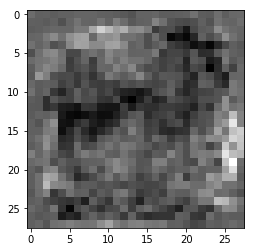

tf.Tensor(
[[ 11.2889408   -6.69690086  -6.43224808 -13.00736736  -6.18951531
   -3.42397768  -1.58312593   2.29200627  -4.90622539   3.08366661]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.65492333e-02, 1.96238887e-03, 0.00000000e+00, 6.48001969e-01,
        1.49959877e-01, 7.26415776e-03, 0.00000000e+00, 7.64007270e-02,
        6.74749073e-03, 1.15177901e-02, 3.20377946e-01, 1.32746622e-03,
        0.00000000e+00, 3.11172171e-03, 2.16425806e-02, 9.12620783e-01,
        1.87629629e-02, 4.76373583e-01, 1.34302959e-01, 0.00000000e+00,
        0.00000000e+00, 9.74264622e-01, 0.00000000e+00, 1.00000000e+00,
        8.14507529e-03, 0.00000000e+00, 4.51018754e-03, 4.04477771e-03,
        9.53898765e-03, 9.81336951e-01, 3.25185478e-01, 1.82790030e-02,
        9.92838502e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.16407645e-01, 0.00000000e+00, 5.31441219e-05,
        8.92237306e-01, 8.87511373e-01,

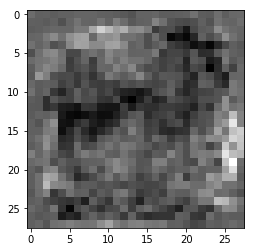

tf.Tensor(
[[ 11.14824728  -6.83934898  -6.38510358 -13.03207017  -5.96224926
   -3.48334875  -1.84240804   2.39787474  -4.79991305   3.36553339]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.70727316e-02, 1.28153875e-03, 0.00000000e+00, 6.46692455e-01,
        1.50515020e-01, 7.11959042e-03, 0.00000000e+00, 7.76488483e-02,
        6.73381565e-03, 1.21246716e-02, 3.21352214e-01, 1.70895702e-03,
        0.00000000e+00, 3.23540554e-03, 2.13372689e-02, 9.13002431e-01,
        1.96107253e-02, 4.76497442e-01, 1.35863304e-01, 0.00000000e+00,
        0.00000000e+00, 9.74583507e-01, 0.00000000e+00, 1.00000000e+00,
        8.81339889e-03, 0.00000000e+00, 4.84960852e-03, 4.44221310e-03,
        9.80999321e-03, 9.80683506e-01, 3.24479461e-01, 1.94773972e-02,
        9.92804170e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.14338946e-01, 0.00000000e+00, 0.00000000e+00,
        8.89694214e-01, 8.84621501e-01,

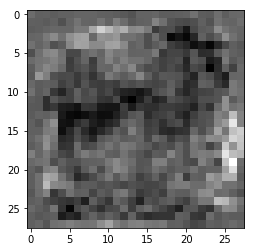

tf.Tensor(
[[ 11.10483003  -6.95810985  -6.32013639 -13.1510034   -5.75318739
   -3.57855869  -2.13210714   2.49551135  -4.73375851   3.65277963]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.76500250e-02, 5.29048382e-04, 0.00000000e+00, 6.45477712e-01,
        1.51023597e-01, 7.00701121e-03, 0.00000000e+00, 7.89032802e-02,
        6.75361371e-03, 1.27915600e-02, 3.22380334e-01, 1.99197186e-03,
        0.00000000e+00, 3.47102946e-03, 2.09393874e-02, 9.13310409e-01,
        2.04840787e-02, 4.76573437e-01, 1.37493834e-01, 0.00000000e+00,
        0.00000000e+00, 9.74858820e-01, 0.00000000e+00, 1.00000000e+00,
        9.56932455e-03, 0.00000000e+00, 5.10590523e-03, 4.82648192e-03,
        1.00905327e-02, 9.79940653e-01, 3.23781669e-01, 2.07054745e-02,
        9.92760837e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.12343323e-01, 0.00000000e+00, 0.00000000e+00,
        8.87104273e-01, 8.81802201e-01,

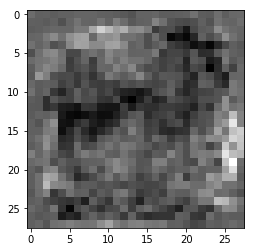

tf.Tensor(
[[ 11.05708921  -7.08295213  -6.27134279 -13.26419078  -5.56803642
   -3.65494316  -2.40497354   2.60308312  -4.67567907   3.9311282 ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.82272028e-02, 0.00000000e+00, 0.00000000e+00, 6.44263208e-01,
        1.51532069e-01, 6.89445436e-03, 0.00000000e+00, 8.01574588e-02,
        6.77340757e-03, 1.34583153e-02, 3.23408246e-01, 2.27493001e-03,
        0.00000000e+00, 3.70660610e-03, 2.05415841e-02, 9.13618326e-01,
        2.13572588e-02, 4.76649433e-01, 1.39124036e-01, 0.00000000e+00,
        0.00000000e+00, 9.75134075e-01, 0.00000000e+00, 1.00000000e+00,
        1.03250984e-02, 0.00000000e+00, 5.36215072e-03, 5.21067390e-03,
        1.03710163e-02, 9.79197919e-01, 3.23084027e-01, 2.19333060e-02,
        9.92717505e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.10348117e-01, 0.00000000e+00, 0.00000000e+00,
        8.84514809e-01, 8.78983438e-01,

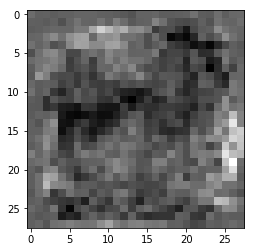

tf.Tensor(
[[ 11.01241935  -7.20552134  -6.22355878 -13.37514654  -5.38915826
   -3.72907531  -2.67467715   2.70936463  -4.61884369   4.20603516]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.88042652e-02, 0.00000000e+00, 0.00000000e+00, 6.43048942e-01,
        1.52040437e-01, 6.78191986e-03, 0.00000000e+00, 8.14113840e-02,
        6.79319771e-03, 1.41249364e-02, 3.24435949e-01, 2.55783182e-03,
        0.00000000e+00, 3.94213572e-03, 2.01438610e-02, 9.13926184e-01,
        2.22302638e-02, 4.76725399e-01, 1.40753910e-01, 0.00000000e+00,
        0.00000000e+00, 9.75409269e-01, 0.00000000e+00, 1.00000000e+00,
        1.10807214e-02, 0.00000000e+00, 5.61834499e-03, 5.59478905e-03,
        1.06514441e-02, 9.78455365e-01, 3.22386503e-01, 2.31608935e-02,
        9.92674172e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.08353329e-01, 0.00000000e+00, 0.00000000e+00,
        8.81925881e-01, 8.76165271e-01,

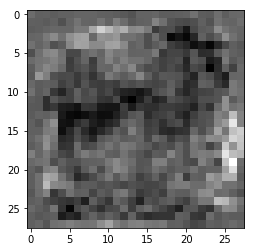

tf.Tensor(
[[ 10.97069527  -7.32618917  -6.1760187  -13.48224956  -5.21684433
   -3.80125033  -2.94060936   2.8130158   -4.56289194   4.47734234]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[1.93812121e-02, 0.00000000e+00, 0.00000000e+00, 6.41834974e-01,
        1.52548701e-01, 6.66940818e-03, 0.00000000e+00, 8.26650634e-02,
        6.81298366e-03, 1.47914244e-02, 3.25463474e-01, 2.84067681e-03,
        0.00000000e+00, 4.17761831e-03, 1.97462179e-02, 9.14233923e-01,
        2.31030937e-02, 4.76801366e-01, 1.42383456e-01, 0.00000000e+00,
        0.00000000e+00, 9.75684404e-01, 0.00000000e+00, 1.00000000e+00,
        1.18361935e-02, 0.00000000e+00, 5.87448804e-03, 5.97882736e-03,
        1.09318150e-02, 9.77712929e-01, 3.21689129e-01, 2.43882351e-02,
        9.92630839e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.06358898e-01, 0.00000000e+00, 0.00000000e+00,
        8.79337490e-01, 8.73347640e-01,

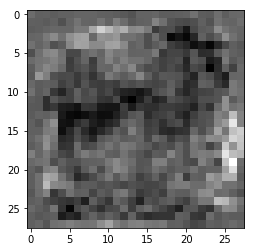

tf.Tensor(
[[ 10.94705178  -7.43044239  -6.15328039 -13.60018379  -5.08284736
   -3.85713826  -3.1272983    2.92044265  -4.55496595   4.68220099]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.10418850e-02, 0.00000000e+00, 0.00000000e+00, 6.41208947e-01,
        1.53009802e-01, 6.03993190e-03, 0.00000000e+00, 8.42786804e-02,
        6.64805854e-03, 1.51026249e-02, 3.25942010e-01, 2.49630190e-03,
        4.18725162e-04, 4.94882464e-03, 2.01209225e-02, 9.14004326e-01,
        2.36501321e-02, 4.78280246e-01, 1.44760177e-01, 0.00000000e+00,
        0.00000000e+00, 9.77489948e-01, 0.00000000e+00, 1.00000000e+00,
        1.31620001e-02, 0.00000000e+00, 5.25792455e-03, 4.78206994e-03,
        1.14215231e-02, 9.76320088e-01, 3.22201401e-01, 2.50230096e-02,
        9.92375374e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.04129267e-01, 0.00000000e+00, 0.00000000e+00,
        8.77245307e-01, 8.69649708e-01,

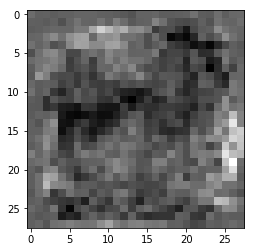

tf.Tensor(
[[ 10.79876045  -7.59782839  -6.28728325 -13.66270488  -4.8267303
   -3.88619302  -3.34540144   3.11116973  -4.63719569   5.01587599]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.14757845e-02, 0.00000000e+00, 0.00000000e+00, 6.40442491e-01,
        1.53608546e-01, 6.17842423e-03, 0.00000000e+00, 8.60709324e-02,
        6.27839938e-03, 1.57234203e-02, 3.27191889e-01, 2.74530100e-03,
        0.00000000e+00, 4.73159505e-03, 2.02576220e-02, 9.14105892e-01,
        2.47118846e-02, 4.78117734e-01, 1.46912456e-01, 0.00000000e+00,
        0.00000000e+00, 9.78123248e-01, 0.00000000e+00, 1.00000000e+00,
        1.40496027e-02, 0.00000000e+00, 5.81077579e-03, 4.98955976e-03,
        1.21817607e-02, 9.75313067e-01, 3.21661681e-01, 2.56574061e-02,
        9.91926670e-01, 4.57412061e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.01617050e-01, 0.00000000e+00, 0.00000000e+00,
        8.74323666e-01, 8.66481423e-01, 

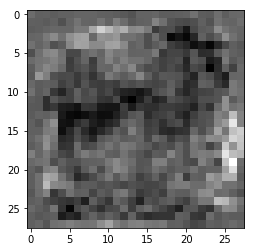

tf.Tensor(
[[ 10.69278962  -7.74575901  -6.35730231 -13.79619332  -4.55527451
   -3.96366933  -3.64538429   3.26808872  -4.70554963   5.36042193]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.18033139e-02, 0.00000000e+00, 0.00000000e+00, 6.39694691e-01,
        1.53556019e-01, 5.92278317e-03, 0.00000000e+00, 8.73566121e-02,
        6.14541071e-03, 1.63610298e-02, 3.28460783e-01, 3.05915112e-03,
        0.00000000e+00, 4.58606333e-03, 2.02436242e-02, 9.14122999e-01,
        2.51880977e-02, 4.78425860e-01, 1.48813784e-01, 1.85652084e-06,
        0.00000000e+00, 9.78897691e-01, 0.00000000e+00, 1.00000000e+00,
        1.50070377e-02, 0.00000000e+00, 5.98181970e-03, 5.05937682e-03,
        1.27404397e-02, 9.74588335e-01, 3.21602225e-01, 2.56450530e-02,
        9.91932750e-01, 1.35939481e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.00731802e-01, 0.00000000e+00, 1.10987108e-04,
        8.72967839e-01, 8.65165174e-01,

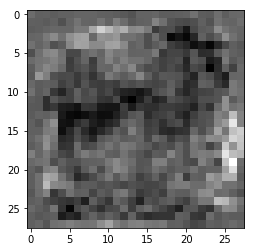

tf.Tensor(
[[ 10.65920885  -7.94592611  -6.49001762 -13.96559107  -4.42844376
   -4.02790664  -3.83791171   3.4235265   -4.82565864   5.6040497 ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.21158881e-02, 0.00000000e+00, 0.00000000e+00, 6.38764381e-01,
        1.53562859e-01, 5.52894408e-03, 6.95893978e-05, 8.83834511e-02,
        5.72137907e-03, 1.68226808e-02, 3.29362273e-01, 3.26406560e-03,
        0.00000000e+00, 4.73169470e-03, 2.00146846e-02, 9.14353430e-01,
        2.57814284e-02, 4.78891432e-01, 1.50212288e-01, 0.00000000e+00,
        0.00000000e+00, 9.79278922e-01, 0.00000000e+00, 1.00000000e+00,
        1.56218270e-02, 0.00000000e+00, 5.82943484e-03, 5.44648105e-03,
        1.33268768e-02, 9.73879933e-01, 3.21277678e-01, 2.57737152e-02,
        9.91676867e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.99957001e-01, 0.00000000e+00, 1.96858076e-04,
        8.71767282e-01, 8.63726854e-01,

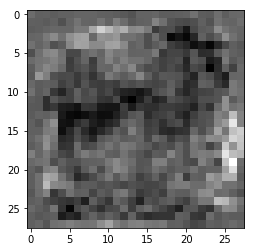

tf.Tensor(
[[ 10.67899221  -8.0929015   -6.56165505 -14.10649171  -4.35424522
   -4.11563191  -3.99826927   3.53106254  -4.90472005   5.7853844 ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.24284008e-02, 0.00000000e+00, 0.00000000e+00, 6.37834251e-01,
        1.53569698e-01, 5.13518369e-03, 1.39164884e-04, 8.94100815e-02,
        5.29743219e-03, 1.72842387e-02, 3.30263585e-01, 3.46893910e-03,
        0.00000000e+00, 4.87729674e-03, 1.97857916e-02, 9.14583802e-01,
        2.63746399e-02, 4.79356915e-01, 1.51610523e-01, 0.00000000e+00,
        0.00000000e+00, 9.79660094e-01, 0.00000000e+00, 1.00000000e+00,
        1.62364934e-02, 0.00000000e+00, 5.67708025e-03, 5.83350752e-03,
        1.39131974e-02, 9.73171651e-01, 3.20953190e-01, 2.59023514e-02,
        9.91421044e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.99182320e-01, 0.00000000e+00, 2.82711873e-04,
        8.70566964e-01, 8.62288833e-01,

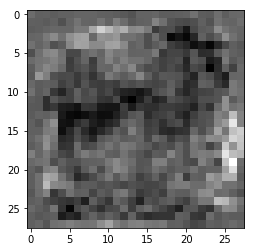

tf.Tensor(
[[ 10.70009626  -8.2396411   -6.63434838 -14.24770778  -4.28232425
   -4.2023418   -4.15776488   3.63875595  -4.98505689   5.96571678]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.27408502e-02, 0.00000000e+00, 0.00000000e+00, 6.36904299e-01,
        1.53576538e-01, 4.74150199e-03, 2.08726444e-04, 9.04365107e-02,
        4.87357005e-03, 1.77457053e-02, 3.31164718e-01, 3.67377163e-03,
        0.00000000e+00, 5.02286991e-03, 1.95569433e-02, 9.14814174e-01,
        2.69677341e-02, 4.79822278e-01, 1.53008476e-01, 0.00000000e+00,
        0.00000000e+00, 9.80041146e-01, 0.00000000e+00, 1.00000000e+00,
        1.68510377e-02, 0.00000000e+00, 5.52475639e-03, 6.22045668e-03,
        1.44994007e-02, 9.72463489e-01, 3.20628762e-01, 2.60309614e-02,
        9.91165280e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.98407817e-01, 0.00000000e+00, 3.68548499e-04,
        8.69366884e-01, 8.60851109e-01,

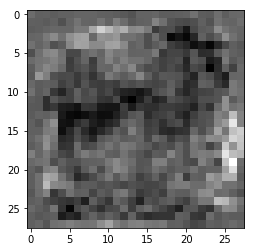

tf.Tensor(
[[ 10.72169434  -8.38583948  -6.70717411 -14.38938025  -4.21109661
   -4.28861391  -4.31583816   3.74565037  -5.06513419   6.1447008 ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.30532382e-02, 0.00000000e+00, 0.00000000e+00, 6.35974526e-01,
        1.53583378e-01, 4.34789946e-03, 2.78274092e-04, 9.14627314e-02,
        4.44979267e-03, 1.82070788e-02, 3.32065672e-01, 3.87856318e-03,
        0.00000000e+00, 5.16841374e-03, 1.93281416e-02, 9.15044487e-01,
        2.75607090e-02, 4.80287552e-01, 1.54406145e-01, 0.00000000e+00,
        0.00000000e+00, 9.80422139e-01, 0.00000000e+00, 1.00000000e+00,
        1.74654592e-02, 0.00000000e+00, 5.37246279e-03, 6.60732854e-03,
        1.50854867e-02, 9.71755505e-01, 3.20304394e-01, 2.61595454e-02,
        9.90909576e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.97633493e-01, 0.00000000e+00, 4.54367953e-04,
        8.68167043e-01, 8.59413683e-01,

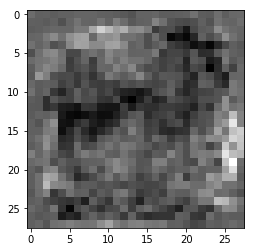

tf.Tensor(
[[ 10.74332635  -8.53160189  -6.77969579 -14.53078485  -4.14051814
   -4.37414158  -4.47290308   3.85181884  -5.1441793    6.32257086]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.33655628e-02, 0.00000000e+00, 0.00000000e+00, 6.35044932e-01,
        1.53590217e-01, 3.95437563e-03, 3.47807829e-04, 9.24887508e-02,
        4.02610004e-03, 1.86683610e-02, 3.32966447e-01, 4.08331398e-03,
        0.00000000e+00, 5.31392870e-03, 1.90993864e-02, 9.15274739e-01,
        2.81535648e-02, 4.80752736e-01, 1.55803531e-01, 0.00000000e+00,
        0.00000000e+00, 9.80803072e-01, 0.00000000e+00, 1.00000000e+00,
        1.80797577e-02, 0.00000000e+00, 5.22019947e-03, 6.99412310e-03,
        1.56714544e-02, 9.71047640e-01, 3.19980085e-01, 2.62881033e-02,
        9.90653932e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.96859288e-01, 0.00000000e+00, 5.40170236e-04,
        8.66967440e-01, 8.57976496e-01,

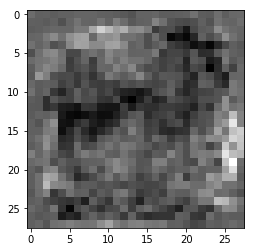

tf.Tensor(
[[ 10.763935    -8.67722099  -6.85202811 -14.67131757  -4.06984709
   -4.45798496  -4.62889828   3.95720109  -5.22183688   6.49943709]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.36778241e-02, 0.00000000e+00, 0.00000000e+00, 6.34115517e-01,
        1.53597057e-01, 3.56093026e-03, 4.17327683e-04, 9.35145617e-02,
        3.60249216e-03, 1.91295501e-02, 3.33867043e-01, 4.28802380e-03,
        0.00000000e+00, 5.45941433e-03, 1.88706759e-02, 9.15504932e-01,
        2.87463032e-02, 4.81217831e-01, 1.57200649e-01, 0.00000000e+00,
        0.00000000e+00, 9.81183946e-01, 0.00000000e+00, 1.00000000e+00,
        1.86939333e-02, 0.00000000e+00, 5.06796688e-03, 7.38084037e-03,
        1.62573066e-02, 9.70339954e-01, 3.19655865e-01, 2.64166370e-02,
        9.90398347e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.96085262e-01, 0.00000000e+00, 6.25955348e-04,
        8.65768075e-01, 8.56539607e-01,

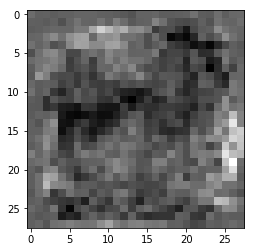

tf.Tensor(
[[ 10.78173879  -8.82937331  -6.92423407 -14.80495807  -4.00526623
   -4.54495867  -4.78502622   4.06626589  -5.29806367   6.67944713]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.38609128e-02, 0.00000000e+00, 0.00000000e+00, 6.33132577e-01,
        1.53707311e-01, 3.15673882e-03, 5.47554169e-04, 9.45864245e-02,
        3.21495906e-03, 1.95941944e-02, 3.34647894e-01, 4.44214744e-03,
        0.00000000e+00, 5.54840360e-03, 1.87232643e-02, 9.15798843e-01,
        2.93632913e-02, 4.81789291e-01, 1.58708528e-01, 0.00000000e+00,
        0.00000000e+00, 9.81673002e-01, 0.00000000e+00, 1.00000000e+00,
        1.92977507e-02, 0.00000000e+00, 4.89348639e-03, 7.95540679e-03,
        1.68561861e-02, 9.69491005e-01, 3.19275260e-01, 2.64984798e-02,
        9.90256310e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.95367682e-01, 0.00000000e+00, 7.65596866e-04,
        8.64607096e-01, 8.55131388e-01,

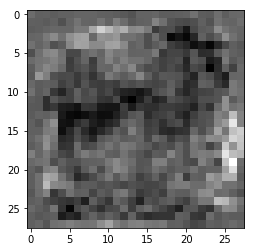

tf.Tensor(
[[ 10.80302699  -8.98945329  -6.99858034 -14.91831969  -3.95589746
   -4.63661111  -4.93762299   4.17799785  -5.37767829   6.86300297]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.41607074e-02, 0.00000000e+00, 0.00000000e+00, 6.32129490e-01,
        1.54532775e-01, 3.18552018e-03, 6.71472924e-04, 9.62141007e-02,
        2.56762234e-03, 2.00401396e-02, 3.35407436e-01, 4.52495227e-03,
        0.00000000e+00, 5.55866817e-03, 1.87413804e-02, 9.16185439e-01,
        3.06230877e-02, 4.81843710e-01, 1.60491288e-01, 0.00000000e+00,
        0.00000000e+00, 9.82006848e-01, 0.00000000e+00, 1.00000000e+00,
        1.98245458e-02, 0.00000000e+00, 5.13830315e-03, 8.68103467e-03,
        1.76761728e-02, 9.68332350e-01, 3.18367332e-01, 2.72905659e-02,
        9.89614785e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.92863691e-01, 0.00000000e+00, 7.34234927e-05,
        8.61727059e-01, 8.51689875e-01,

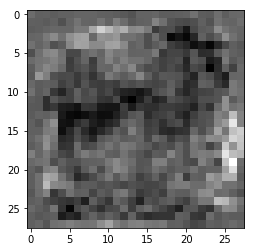

tf.Tensor(
[[ 10.75383683  -9.07446379  -6.99104376 -14.98663642  -3.82576926
   -4.72225394  -5.14190653   4.2792003   -5.39722432   7.0485356 ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.43436992e-02, 0.00000000e+00, 0.00000000e+00, 6.31146908e-01,
        1.54642835e-01, 2.78140395e-03, 8.01648595e-04, 9.72854197e-02,
        2.18029600e-03, 2.05046013e-02, 3.36187959e-01, 4.67902841e-03,
        0.00000000e+00, 5.64763742e-03, 1.85939949e-02, 9.16479170e-01,
        3.12397014e-02, 4.82415050e-01, 1.61998510e-01, 0.00000000e+00,
        0.00000000e+00, 9.82495785e-01, 0.00000000e+00, 1.00000000e+00,
        2.04281379e-02, 0.00000000e+00, 4.96380869e-03, 9.25534125e-03,
        1.82747673e-02, 9.67483759e-01, 3.17986995e-01, 2.73722336e-02,
        9.89472866e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.92146707e-01, 0.00000000e+00, 2.13175503e-04,
        8.60566854e-01, 8.50282609e-01,

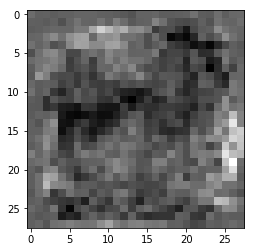

tf.Tensor(
[[ 10.78061553  -9.23454038  -7.06226203 -15.10330899  -3.77840831
   -4.81602213  -5.29654108   4.38942706  -5.47865292   7.23430691]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.54168957e-02, 0.00000000e+00, 0.00000000e+00, 6.30041897e-01,
        1.54810816e-01, 2.32119299e-03, 0.00000000e+00, 9.91507992e-02,
        2.37660157e-03, 2.12494470e-02, 3.36564124e-01, 3.78822931e-03,
        1.39618511e-04, 6.51303306e-03, 1.92208458e-02, 9.16444957e-01,
        3.20334211e-02, 4.84124660e-01, 1.64400533e-01, 0.00000000e+00,
        0.00000000e+00, 9.83712971e-01, 0.00000000e+00, 1.00000000e+00,
        2.18134969e-02, 0.00000000e+00, 4.03829897e-03, 9.07457806e-03,
        1.89179145e-02, 9.66209710e-01, 3.18005860e-01, 2.79014260e-02,
        9.88632917e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.90738964e-01, 0.00000000e+00, 1.28668139e-03,
        8.59787345e-01, 8.47899854e-01,

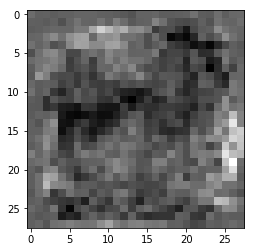

tf.Tensor(
[[ 10.72011986  -9.406863    -7.11387581 -15.11194598  -3.72002552
   -4.89543982  -5.43086033   4.47887987  -5.495161     7.41244506]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.55996361e-02, 0.00000000e+00, 0.00000000e+00, 6.29059732e-01,
        1.54920816e-01, 1.91724952e-03, 1.30309971e-04, 1.00221530e-01,
        1.98931363e-03, 2.17136666e-02, 3.37344438e-01, 3.94245284e-03,
        0.00000000e+00, 6.60181139e-03, 1.90733634e-02, 9.16738689e-01,
        3.26497518e-02, 4.84695524e-01, 1.65906981e-01, 0.00000000e+00,
        0.00000000e+00, 9.84201550e-01, 0.00000000e+00, 1.00000000e+00,
        2.24166904e-02, 0.00000000e+00, 3.86402453e-03, 9.64880548e-03,
        1.95162613e-02, 9.65361595e-01, 3.17625612e-01, 2.79829726e-02,
        9.88491237e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.90022457e-01, 0.00000000e+00, 1.42619072e-03,
        8.58627558e-01, 8.46493363e-01,

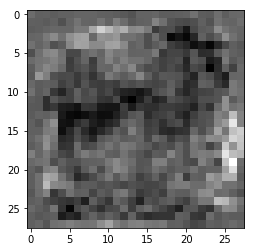

tf.Tensor(
[[ 10.74183681  -9.57415138  -7.18408517 -15.23248322  -3.6680381
   -4.995679    -5.59343788   4.59174378  -5.57111017   7.60519845]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.57801302e-02, 0.00000000e+00, 0.00000000e+00, 6.28076315e-01,
        1.55043468e-01, 1.51453179e-03, 2.69413344e-04, 1.01298548e-01,
        1.61695795e-03, 2.21912432e-02, 3.38101000e-01, 4.11911355e-03,
        0.00000000e+00, 6.66829525e-03, 1.89210009e-02, 9.17052805e-01,
        3.32597867e-02, 4.85293955e-01, 1.67439848e-01, 0.00000000e+00,
        0.00000000e+00, 9.84697223e-01, 0.00000000e+00, 1.00000000e+00,
        2.30287723e-02, 0.00000000e+00, 3.68525181e-03, 1.02532562e-02,
        2.01196615e-02, 9.64495957e-01, 3.17237973e-01, 2.80654933e-02,
        9.88351107e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.89302552e-01, 0.00000000e+00, 1.59552169e-03,
        8.57464433e-01, 8.45046997e-01, 

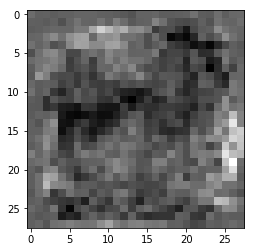

tf.Tensor(
[[ 10.76776495  -9.73635855  -7.24616142 -15.344289    -3.62888097
   -5.09485904  -5.75268622   4.70016192  -5.63909093   7.79112417]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.59782318e-02, 0.00000000e+00, 0.00000000e+00, 6.27273917e-01,
        1.55000210e-01, 1.28204224e-03, 5.25066978e-04, 1.02421664e-01,
        1.15654897e-03, 2.24898271e-02, 3.38895023e-01, 4.23415238e-03,
        0.00000000e+00, 6.99128956e-03, 1.88909303e-02, 9.17419672e-01,
        3.39761972e-02, 4.85719770e-01, 1.68753669e-01, 0.00000000e+00,
        0.00000000e+00, 9.85058427e-01, 0.00000000e+00, 1.00000000e+00,
        2.35237293e-02, 0.00000000e+00, 3.48346261e-03, 1.06423637e-02,
        2.06358861e-02, 9.63642240e-01, 3.16973001e-01, 2.82153934e-02,
        9.88112271e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.88571262e-01, 0.00000000e+00, 1.77905196e-03,
        8.56627345e-01, 8.44070852e-01,

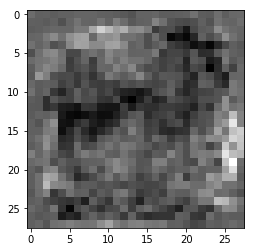

tf.Tensor(
[[ 10.8214498   -9.87124679  -7.30015891 -15.44579154  -3.61563359
   -5.18411924  -5.90606837   4.79872407  -5.70582156   7.9605319 ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.61762943e-02, 0.00000000e+00, 0.00000000e+00, 6.26471639e-01,
        1.54956967e-01, 1.04959914e-03, 7.80669507e-04, 1.03544548e-01,
        6.96232077e-04, 2.27883514e-02, 3.39688897e-01, 4.34916839e-03,
        0.00000000e+00, 7.31421914e-03, 1.88608654e-02, 9.17786419e-01,
        3.46924625e-02, 4.86145496e-01, 1.70067221e-01, 0.00000000e+00,
        0.00000000e+00, 9.85419571e-01, 0.00000000e+00, 1.00000000e+00,
        2.40185875e-02, 0.00000000e+00, 3.28171370e-03, 1.10313939e-02,
        2.11520083e-02, 9.62788701e-01, 3.16708088e-01, 2.83652619e-02,
        9.87873495e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.87840152e-01, 0.00000000e+00, 1.96254556e-03,
        8.55790436e-01, 8.43094885e-01,

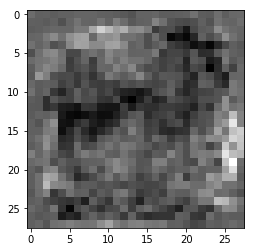

tf.Tensor(
[[ 10.87379576 -10.00512875  -7.35321536 -15.54468895  -3.60233471
   -5.27264116  -6.05926286   4.8969436   -5.77133762   8.12933871]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.63743177e-02, 0.00000000e+00, 0.00000000e+00, 6.25669539e-01,
        1.54913723e-01, 8.17202555e-04, 1.03622093e-03, 1.04667209e-01,
        2.36007210e-04, 2.30868161e-02, 3.40482593e-01, 4.46416112e-03,
        0.00000000e+00, 7.63708400e-03, 1.88308060e-02, 9.18153107e-01,
        3.54085863e-02, 4.86571133e-01, 1.71380520e-01, 0.00000000e+00,
        0.00000000e+00, 9.85780656e-01, 0.00000000e+00, 1.00000000e+00,
        2.45133471e-02, 0.00000000e+00, 3.08000529e-03, 1.14203459e-02,
        2.16680281e-02, 9.61935341e-01, 3.16443235e-01, 2.85151005e-02,
        9.87634718e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.87109160e-01, 0.00000000e+00, 2.14600237e-03,
        8.54953706e-01, 8.42119098e-01,

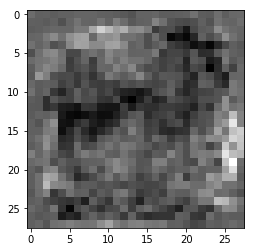

tf.Tensor(
[[ 10.92097883 -10.14036399  -7.4069325  -15.64432055  -3.58814148
   -5.35700995  -6.21365251   4.99658315  -5.8353763    8.29619895]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.66251490e-02, 0.00000000e+00, 0.00000000e+00, 6.24894559e-01,
        1.54880315e-01, 6.15325582e-04, 1.20034511e-03, 1.05762497e-01,
        0.00000000e+00, 2.33426522e-02, 3.41333210e-01, 4.54200245e-03,
        0.00000000e+00, 8.00939649e-03, 1.87432580e-02, 9.18471575e-01,
        3.62190269e-02, 4.86876756e-01, 1.72659427e-01, 0.00000000e+00,
        0.00000000e+00, 9.86121118e-01, 0.00000000e+00, 1.00000000e+00,
        2.50492357e-02, 0.00000000e+00, 2.85915681e-03, 1.17357522e-02,
        2.21608989e-02, 9.61170077e-01, 3.16184431e-01, 2.87230648e-02,
        9.87335324e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.86288285e-01, 0.00000000e+00, 2.21343781e-03,
        8.53911459e-01, 8.40968370e-01,

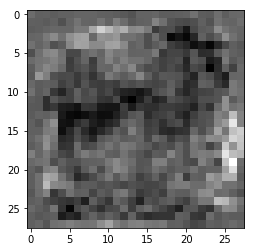

tf.Tensor(
[[ 10.95745674 -10.27017749  -7.46590004 -15.74539198  -3.57068817
   -5.42623912  -6.37306982   5.09182418  -5.90289807   8.46025332]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.68520527e-02, 0.00000000e+00, 0.00000000e+00, 6.24162436e-01,
        1.54853180e-01, 3.98926204e-04, 1.28453609e-03, 1.06819399e-01,
        0.00000000e+00, 2.35838220e-02, 3.42201859e-01, 4.63902950e-03,
        0.00000000e+00, 8.37394223e-03, 1.87105704e-02, 9.18821573e-01,
        3.70255336e-02, 4.87117141e-01, 1.73978344e-01, 0.00000000e+00,
        0.00000000e+00, 9.86522257e-01, 0.00000000e+00, 1.00000000e+00,
        2.56053247e-02, 0.00000000e+00, 2.68065464e-03, 1.20237544e-02,
        2.26377547e-02, 9.60401416e-01, 3.15979540e-01, 2.88701989e-02,
        9.87080455e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.85472655e-01, 0.00000000e+00, 2.37982580e-03,
        8.52944970e-01, 8.39994133e-01,

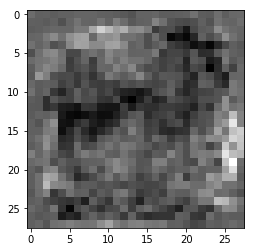

tf.Tensor(
[[ 10.97789249 -10.39970406  -7.53551106 -15.83311171  -3.56040947
   -5.4717526   -6.53644747   5.19139988  -5.97094334   8.62399214]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.71762591e-02, 0.00000000e+00, 0.00000000e+00, 6.23444378e-01,
        1.54706270e-01, 6.61580416e-05, 1.40014733e-03, 1.07777879e-01,
        0.00000000e+00, 2.38115806e-02, 3.43170583e-01, 4.75100474e-03,
        0.00000000e+00, 8.79929774e-03, 1.86330508e-02, 9.19238508e-01,
        3.78593877e-02, 4.87444401e-01, 1.75186172e-01, 0.00000000e+00,
        0.00000000e+00, 9.86792147e-01, 0.00000000e+00, 1.00000000e+00,
        2.61497628e-02, 0.00000000e+00, 2.59728776e-03, 1.22277336e-02,
        2.32325811e-02, 9.59659755e-01, 3.15708071e-01, 2.89379675e-02,
        9.86914396e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.84766698e-01, 0.00000000e+00, 2.49702064e-03,
        8.52140486e-01, 8.39245498e-01,

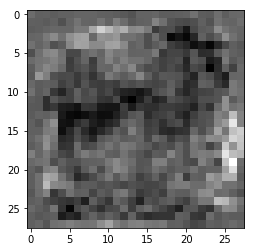

tf.Tensor(
[[ 10.99448279 -10.52938938  -7.61386933 -15.92180608  -3.56072791
   -5.52055728  -6.70067165   5.2966802   -6.04610944   8.7859101 ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.75280774e-02, 0.00000000e+00, 0.00000000e+00, 6.22759581e-01,
        1.54579669e-01, 0.00000000e+00, 1.53697678e-03, 1.08769923e-01,
        0.00000000e+00, 2.40297262e-02, 3.44178021e-01, 4.87324037e-03,
        0.00000000e+00, 9.20283329e-03, 1.85227096e-02, 9.19628441e-01,
        3.86862643e-02, 4.87779677e-01, 1.76405162e-01, 0.00000000e+00,
        0.00000000e+00, 9.87066448e-01, 0.00000000e+00, 1.00000000e+00,
        2.67232228e-02, 0.00000000e+00, 2.48533511e-03, 1.23731466e-02,
        2.38708369e-02, 9.58964765e-01, 3.15437585e-01, 2.90281158e-02,
        9.86691594e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.84080648e-01, 0.00000000e+00, 2.59680487e-03,
        8.51305187e-01, 8.38469863e-01,

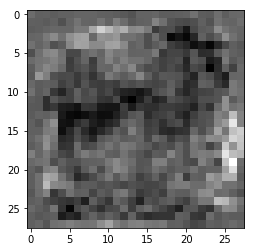

tf.Tensor(
[[ 11.00662594 -10.66014951  -7.69501248 -16.01893321  -3.55625029
   -5.57823259  -6.86794105   5.39673335  -6.13175629   8.95100016]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.78561339e-02, 0.00000000e+00, 0.00000000e+00, 6.22126758e-01,
        1.54465377e-01, 0.00000000e+00, 1.69818325e-03, 1.09829016e-01,
        0.00000000e+00, 2.42302660e-02, 3.45148087e-01, 5.00024483e-03,
        0.00000000e+00, 9.53651033e-03, 1.84187349e-02, 9.19950008e-01,
        3.95376161e-02, 4.88118619e-01, 1.77561760e-01, 0.00000000e+00,
        0.00000000e+00, 9.87362325e-01, 0.00000000e+00, 1.00000000e+00,
        2.72513088e-02, 0.00000000e+00, 2.37558829e-03, 1.25224395e-02,
        2.45464519e-02, 9.58285570e-01, 3.15152317e-01, 2.90597994e-02,
        9.86415923e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.83437037e-01, 0.00000000e+00, 2.70864484e-03,
        8.50574434e-01, 8.37713778e-01,

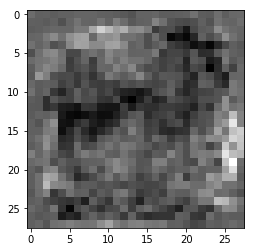

tf.Tensor(
[[ 11.03390025 -10.79684868  -7.77720539 -16.11776561  -3.56480812
   -5.64095151  -7.0276595    5.4900852   -6.22305804   9.10906448]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.80997735e-02, 0.00000000e+00, 0.00000000e+00, 6.21457338e-01,
        1.54341623e-01, 0.00000000e+00, 1.83178077e-03, 1.10731453e-01,
        0.00000000e+00, 2.43671928e-02, 3.46065909e-01, 5.03638154e-03,
        0.00000000e+00, 9.95574147e-03, 1.83493793e-02, 9.20434296e-01,
        4.03694175e-02, 4.88483161e-01, 1.78612173e-01, 0.00000000e+00,
        0.00000000e+00, 9.87629473e-01, 0.00000000e+00, 1.00000000e+00,
        2.76726075e-02, 0.00000000e+00, 2.23377952e-03, 1.27383564e-02,
        2.51131766e-02, 9.57576454e-01, 3.14916432e-01, 2.91098971e-02,
        9.86290574e-01, 0.00000000e+00, 0.00000000e+00, 2.67588111e-05,
        0.00000000e+00, 8.82910609e-01, 0.00000000e+00, 2.84832157e-03,
        8.49950373e-01, 8.37224603e-01,

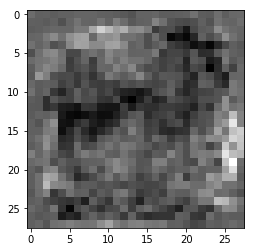

tf.Tensor(
[[ 11.07303982 -10.93247058  -7.86336709 -16.19901046  -3.6074606
   -5.68129023  -7.17172153   5.57834585  -6.304472     9.25384934]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.84572728e-02, 0.00000000e+00, 0.00000000e+00, 6.20768249e-01,
        1.54915765e-01, 9.72751368e-05, 1.95922237e-03, 1.12176239e-01,
        0.00000000e+00, 2.44859383e-02, 3.46962899e-01, 5.00295404e-03,
        0.00000000e+00, 1.02980928e-02, 1.84415169e-02, 9.21009004e-01,
        4.18283753e-02, 4.88343269e-01, 1.79930866e-01, 0.00000000e+00,
        0.00000000e+00, 9.87745225e-01, 0.00000000e+00, 1.00000000e+00,
        2.80187875e-02, 0.00000000e+00, 2.50108168e-03, 1.31017361e-02,
        2.58956458e-02, 9.56565142e-01, 3.14165980e-01, 2.98530012e-02,
        9.85677898e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.80641103e-01, 0.00000000e+00, 2.17637885e-03,
        8.47648859e-01, 8.34751308e-01, 

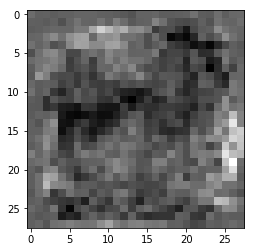

tf.Tensor(
[[ 11.04902214 -10.99466932  -7.86982137 -16.2284349   -3.58661657
   -5.7118434   -7.34923986   5.65197943  -6.33032921   9.3911573 ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.87007913e-02, 0.00000000e+00, 0.00000000e+00, 6.20099068e-01,
        1.54791921e-01, 0.00000000e+00, 2.09276774e-03, 1.13078207e-01,
        0.00000000e+00, 2.46228129e-02, 3.47880363e-01, 5.03909029e-03,
        0.00000000e+00, 1.07171712e-02, 1.83721576e-02, 9.21493053e-01,
        4.26597185e-02, 4.88707781e-01, 1.80980802e-01, 0.00000000e+00,
        0.00000000e+00, 9.88012314e-01, 0.00000000e+00, 1.00000000e+00,
        2.84399316e-02, 0.00000000e+00, 2.35924777e-03, 1.33175375e-02,
        2.64621004e-02, 9.55856383e-01, 3.13930303e-01, 2.99029406e-02,
        9.85552728e-01, 0.00000000e+00, 0.00000000e+00, 2.67588111e-05,
        0.00000000e+00, 8.80115211e-01, 0.00000000e+00, 2.31616199e-03,
        8.47025394e-01, 8.34262729e-01,

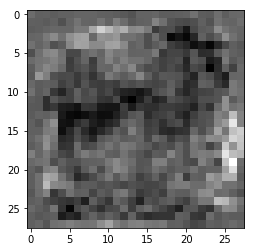

tf.Tensor(
[[ 11.08830254 -11.13229528  -7.95397476 -16.31050814  -3.6268663
   -5.75683842  -7.4972675    5.73983555  -6.40984654   9.54050949]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.89442614e-02, 0.00000000e+00, 0.00000000e+00, 6.19430006e-01,
        1.54668108e-01, 0.00000000e+00, 2.22628633e-03, 1.13979995e-01,
        0.00000000e+00, 2.47596595e-02, 3.48797619e-01, 5.07521955e-03,
        0.00000000e+00, 1.11361658e-02, 1.83028113e-02, 9.21977043e-01,
        4.34908979e-02, 4.89072204e-01, 1.82030529e-01, 0.00000000e+00,
        0.00000000e+00, 9.88279343e-01, 0.00000000e+00, 1.00000000e+00,
        2.88609918e-02, 0.00000000e+00, 2.21744226e-03, 1.35332951e-02,
        2.70284433e-02, 9.55147743e-01, 3.13694656e-01, 2.99528688e-02,
        9.85427558e-01, 0.00000000e+00, 0.00000000e+00, 5.35122672e-05,
        0.00000000e+00, 8.79589438e-01, 0.00000000e+00, 2.45591719e-03,
        8.46402049e-01, 8.33774209e-01, 

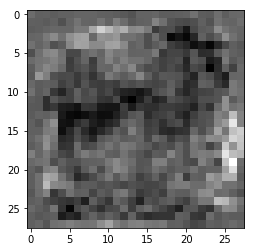

tf.Tensor(
[[ 11.12635023 -11.26855113  -8.03802022 -16.39104159  -3.66769347
   -5.79888283  -7.64409874   5.82618299  -6.48857121   9.68812449]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.91876830e-02, 0.00000000e+00, 0.00000000e+00, 6.18761122e-01,
        1.54544309e-01, 0.00000000e+00, 2.35977815e-03, 1.14881597e-01,
        0.00000000e+00, 2.48964801e-02, 3.49714696e-01, 5.11134136e-03,
        0.00000000e+00, 1.15550766e-02, 1.82334781e-02, 9.22460914e-01,
        4.43219095e-02, 4.89436567e-01, 1.83080047e-01, 0.00000000e+00,
        0.00000000e+00, 9.88546312e-01, 0.00000000e+00, 1.00000000e+00,
        2.92819683e-02, 0.00000000e+00, 2.07566516e-03, 1.37490099e-02,
        2.75946725e-02, 9.54439223e-01, 3.13459069e-01, 3.00027877e-02,
        9.85302389e-01, 0.00000000e+00, 0.00000000e+00, 8.02603754e-05,
        0.00000000e+00, 8.79063785e-01, 0.00000000e+00, 2.59564444e-03,
        8.45778823e-01, 8.33285809e-01,

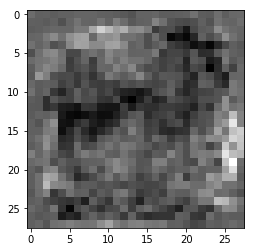

tf.Tensor(
[[ 11.15657484 -11.40713324  -8.12559054 -16.47498223  -3.70579004
   -5.84153126  -7.79283455   5.90745559  -6.5664716    9.83054765]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[2.94853896e-02, 0.00000000e+00, 0.00000000e+00, 6.18131876e-01,
        1.54663801e-01, 0.00000000e+00, 2.39914865e-03, 1.15665928e-01,
        0.00000000e+00, 2.49488596e-02, 3.50681722e-01, 5.21544600e-03,
        0.00000000e+00, 1.20511670e-02, 1.78511515e-02, 9.22815800e-01,
        4.53070775e-02, 4.89766389e-01, 1.84067607e-01, 0.00000000e+00,
        0.00000000e+00, 9.88835156e-01, 0.00000000e+00, 1.00000000e+00,
        2.97238901e-02, 0.00000000e+00, 2.00287928e-03, 1.39666060e-02,
        2.81218495e-02, 9.53991950e-01, 3.13075244e-01, 3.01267169e-02,
        9.84912574e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.78681958e-01, 0.00000000e+00, 3.16889933e-03,
        8.45543683e-01, 8.33145857e-01,

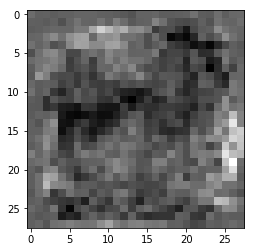

tf.Tensor(
[[ 11.18139986 -11.55094166  -8.2208903  -16.59492053  -3.72842693
   -5.87666924  -7.91310874   5.9753635   -6.65839466   9.95392598]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.06753181e-02, 0.00000000e+00, 0.00000000e+00, 6.17379844e-01,
        1.54841349e-01, 0.00000000e+00, 1.49685435e-03, 1.17246188e-01,
        8.10792553e-05, 2.52823476e-02, 3.51243407e-01, 4.27229004e-03,
        5.76163642e-04, 1.33253830e-02, 1.82448830e-02, 9.22841907e-01,
        4.64696847e-02, 4.91237164e-01, 1.85952112e-01, 0.00000000e+00,
        1.13763577e-04, 9.89854038e-01, 0.00000000e+00, 1.00000000e+00,
        3.09494045e-02, 0.00000000e+00, 1.17733586e-03, 1.34274727e-02,
        2.86936946e-02, 9.53118086e-01, 3.13091546e-01, 3.06991879e-02,
        9.83823121e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.77607703e-01, 6.30481227e-04, 4.67796251e-03,
        8.45689893e-01, 8.32027912e-01,

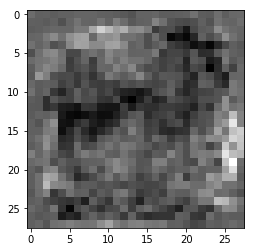

tf.Tensor(
[[ 11.11470862 -11.71254409  -8.29195139 -16.62347789  -3.72747431
   -5.91007476  -8.02869726   6.01868591  -6.67490527  10.08241269]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.09727266e-02, 0.00000000e+00, 0.00000000e+00, 6.16750896e-01,
        1.54960781e-01, 0.00000000e+00, 1.53639738e-03, 1.18030041e-01,
        0.00000000e+00, 2.53346488e-02, 3.52210104e-01, 4.37656278e-03,
        4.60926036e-04, 1.38211194e-02, 1.78625546e-02, 9.23196673e-01,
        4.74544205e-02, 4.91566628e-01, 1.86939090e-01, 0.00000000e+00,
        4.99531452e-05, 9.90142643e-01, 0.00000000e+00, 1.00000000e+00,
        3.13909911e-02, 0.00000000e+00, 1.10472960e-03, 1.36451330e-02,
        2.92206518e-02, 9.52671051e-01, 3.12707782e-01, 3.08229774e-02,
        9.83433604e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.77226174e-01, 0.00000000e+00, 5.25080087e-03,
        8.45454812e-01, 8.31888199e-01,

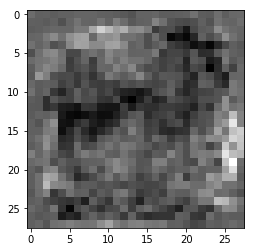

tf.Tensor(
[[ 11.13564623 -11.86506461  -8.39193665 -16.75309794  -3.74112948
   -5.9562721   -8.16674088   6.08933172  -6.76452883  10.22114679]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.12700756e-02, 0.00000000e+00, 0.00000000e+00, 6.16122067e-01,
        1.55080184e-01, 0.00000000e+00, 1.57593249e-03, 1.18813738e-01,
        0.00000000e+00, 2.53869388e-02, 3.53176624e-01, 4.48081456e-03,
        3.45711480e-04, 1.43167572e-02, 1.74803026e-02, 9.23551381e-01,
        4.84389588e-02, 4.91896033e-01, 1.87925875e-01, 0.00000000e+00,
        0.00000000e+00, 9.90431190e-01, 0.00000000e+00, 1.00000000e+00,
        3.18324901e-02, 0.00000000e+00, 1.03213789e-03, 1.38627496e-02,
        2.97475029e-02, 9.52224135e-01, 3.12324107e-01, 3.09467427e-02,
        9.83044147e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.76844764e-01, 0.00000000e+00, 5.82352467e-03,
        8.45219791e-01, 8.31748545e-01,

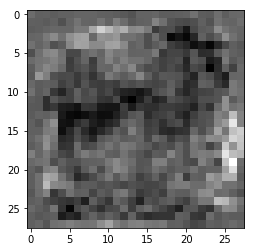

tf.Tensor(
[[ 11.15137363 -12.01359939  -8.49032779 -16.87303172  -3.7548127
   -5.99671999  -8.30102897   6.15652968  -6.84966129  10.35632999]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.15673649e-02, 0.00000000e+00, 0.00000000e+00, 6.15493357e-01,
        1.55199572e-01, 0.00000000e+00, 1.61545968e-03, 1.19597279e-01,
        0.00000000e+00, 2.54392195e-02, 3.54142934e-01, 4.58504539e-03,
        2.30519974e-04, 1.48122953e-02, 1.70981269e-02, 9.23906028e-01,
        4.94232997e-02, 4.92225379e-01, 1.88912466e-01, 0.00000000e+00,
        0.00000000e+00, 9.90719676e-01, 0.00000000e+00, 1.00000000e+00,
        3.22738998e-02, 0.00000000e+00, 9.59560683e-04, 1.40803223e-02,
        3.02742496e-02, 9.51777279e-01, 3.11940521e-01, 3.10704838e-02,
        9.82654750e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.76463413e-01, 0.00000000e+00, 6.39613392e-03,
        8.44984770e-01, 8.31608891e-01, 

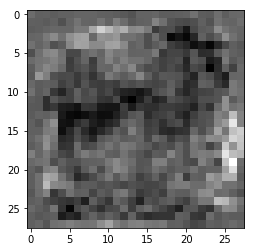

tf.Tensor(
[[ 11.16577934 -12.16423538  -8.59343873 -16.98516155  -3.77282663
   -6.02705524  -8.42847097   6.2258326   -6.94050851  10.48760296]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.23252007e-02, 0.00000000e+00, 0.00000000e+00, 6.14800692e-01,
        1.55526862e-01, 3.67529341e-04, 2.14175833e-03, 1.20488189e-01,
        0.00000000e+00, 2.54010614e-02, 3.55235487e-01, 4.50961897e-03,
        0.00000000e+00, 1.45695088e-02, 1.71235763e-02, 9.24303889e-01,
        5.11681177e-02, 4.92207766e-01, 1.90281436e-01, 0.00000000e+00,
        0.00000000e+00, 9.90679324e-01, 0.00000000e+00, 1.00000000e+00,
        3.31695005e-02, 0.00000000e+00, 1.75921572e-03, 1.48165217e-02,
        3.08972448e-02, 9.50785220e-01, 3.11256558e-01, 3.16201933e-02,
        9.81930494e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.74542773e-01, 0.00000000e+00, 5.82932215e-03,
        8.42936814e-01, 8.29411983e-01,

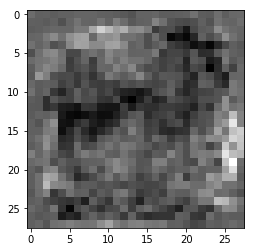

tf.Tensor(
[[ 11.10315658 -12.33022085  -8.63630639 -17.01696329  -3.76709004
   -6.02649721  -8.67224736   6.27043415  -6.99474032  10.69147942]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.35165858e-02, 0.00000000e+00, 0.00000000e+00, 6.13525927e-01,
        1.55746996e-01, 6.49254769e-04, 2.58155959e-03, 1.20250270e-01,
        0.00000000e+00, 2.53880452e-02, 3.56212586e-01, 4.22665756e-03,
        0.00000000e+00, 1.38163008e-02, 1.64346397e-02, 9.24725354e-01,
        5.26402555e-02, 4.92442787e-01, 1.91071436e-01, 0.00000000e+00,
        5.48550102e-04, 9.90224898e-01, 0.00000000e+00, 9.99657691e-01,
        3.43668498e-02, 0.00000000e+00, 1.69411360e-03, 1.57208126e-02,
        3.18560712e-02, 9.49566722e-01, 3.10652077e-01, 3.14097330e-02,
        9.81275320e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.73576522e-01, 0.00000000e+00, 6.07299386e-03,
        8.42434525e-01, 8.28580916e-01,

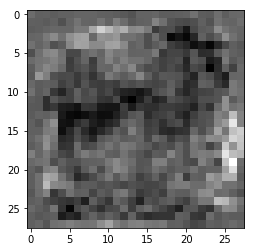

tf.Tensor(
[[ 10.96295803 -12.54959572  -8.70464302 -16.94454929  -3.82586776
   -5.85056316  -9.07070467   6.27793209  -7.12687194  11.02485672]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.47077325e-02, 0.00000000e+00, 0.00000000e+00, 6.12251401e-01,
        1.55967087e-01, 9.30923852e-04, 3.02127283e-03, 1.20012395e-01,
        0.00000000e+00, 2.53750328e-02, 3.57189476e-01, 3.94375296e-03,
        0.00000000e+00, 1.30632436e-02, 1.57458410e-02, 9.25146759e-01,
        5.41120991e-02, 4.92677778e-01, 1.91861272e-01, 0.00000000e+00,
        1.09699043e-03, 9.89770591e-01, 0.00000000e+00, 9.99315441e-01,
        3.55639569e-02, 0.00000000e+00, 1.62902439e-03, 1.66249219e-02,
        3.28147039e-02, 9.48348463e-01, 3.10047716e-01, 3.11993156e-02,
        9.80620265e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.72610450e-01, 0.00000000e+00, 6.31661667e-03,
        8.41932356e-01, 8.27750027e-01,

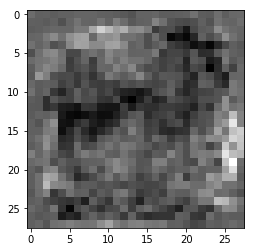

tf.Tensor(
[[ 10.79781448 -12.76198308  -8.79913947 -16.85491515  -3.87704075
   -5.66365352  -9.49247839   6.2863757   -7.25756413  11.37042659]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.60375494e-02, 0.00000000e+00, 0.00000000e+00, 6.10876322e-01,
        1.56209081e-01, 1.29668578e-03, 3.43298470e-03, 1.19530052e-01,
        0.00000000e+00, 2.54192241e-02, 3.58081520e-01, 3.61189642e-03,
        0.00000000e+00, 1.21976975e-02, 1.50973136e-02, 9.25643802e-01,
        5.56562059e-02, 4.92802799e-01, 1.92760482e-01, 0.00000000e+00,
        1.72309298e-03, 9.89317417e-01, 0.00000000e+00, 9.98868227e-01,
        3.69889587e-02, 0.00000000e+00, 1.67041237e-03, 1.76200755e-02,
        3.37784812e-02, 9.47061837e-01, 3.09441745e-01, 3.09641045e-02,
        9.80148911e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.71569157e-01, 0.00000000e+00, 6.52094185e-03,
        8.41318309e-01, 8.26765656e-01,

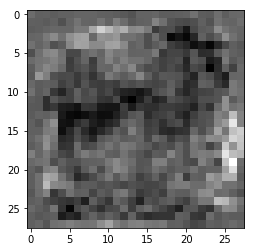

tf.Tensor(
[[ 10.54461483 -12.97294759  -8.94236539 -16.68772687  -3.92779496
   -5.40206865 -10.01093743   6.28724642  -7.39101499  11.77355179]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.73671018e-02, 0.00000000e+00, 0.00000000e+00, 6.09501481e-01,
        1.56451032e-01, 1.66237447e-03, 3.84461414e-03, 1.19047806e-01,
        0.00000000e+00, 2.54634060e-02, 3.58973384e-01, 3.28010623e-03,
        0.00000000e+00, 1.13323247e-02, 1.44489156e-02, 9.26140785e-01,
        5.72000034e-02, 4.92927790e-01, 1.93659514e-01, 0.00000000e+00,
        2.34907051e-03, 9.88864362e-01, 0.00000000e+00, 9.98421133e-01,
        3.84136736e-02, 0.00000000e+00, 1.71179208e-03, 1.86150298e-02,
        3.47420648e-02, 9.45775449e-01, 3.08835894e-01, 3.07289399e-02,
        9.79677677e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.70528102e-01, 0.00000000e+00, 6.72522606e-03,
        8.40704381e-01, 8.25781524e-01,

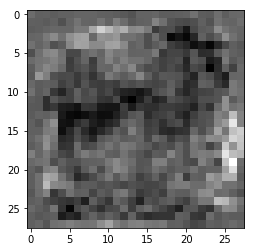

tf.Tensor(
[[ 10.29338343 -13.18243166  -9.08463019 -16.51900309  -3.98052422
   -5.14031118 -10.52666164   6.28801883  -7.52298415  12.17446004]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.86963859e-02, 0.00000000e+00, 0.00000000e+00, 6.08126938e-01,
        1.56692937e-01, 2.02799006e-03, 4.25616140e-03, 1.18565656e-01,
        0.00000000e+00, 2.55075805e-02, 3.59865069e-01, 2.94838240e-03,
        0.00000000e+00, 1.04671251e-02, 1.38006471e-02, 9.26637650e-01,
        5.87434918e-02, 4.93052751e-01, 1.94558367e-01, 0.00000000e+00,
        2.97492277e-03, 9.88411367e-01, 0.00000000e+00, 9.97974098e-01,
        3.98381054e-02, 0.00000000e+00, 1.75316352e-03, 1.96097847e-02,
        3.57054546e-02, 9.44489360e-01, 3.08230162e-01, 3.04938219e-02,
        9.79206562e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.69487226e-01, 0.00000000e+00, 6.92946929e-03,
        8.40090573e-01, 8.24797571e-01,

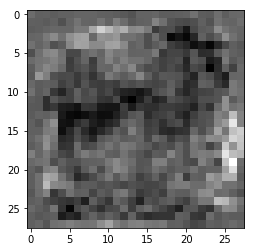

tf.Tensor(
[[ 10.02868436 -13.38000164  -9.2259309  -16.34247254  -4.05524842
   -4.87491721 -11.06331097   6.28084617  -7.66020752  12.57762805]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[3.99432927e-02, 0.00000000e+00, 0.00000000e+00, 6.06844187e-01,
        1.57096133e-01, 2.32561026e-03, 4.99788858e-03, 1.18320800e-01,
        0.00000000e+00, 2.57290546e-02, 3.60654473e-01, 2.70876731e-03,
        0.00000000e+00, 9.70258098e-03, 1.30281113e-02, 9.27153885e-01,
        6.03475608e-02, 4.93404478e-01, 1.95596725e-01, 0.00000000e+00,
        3.53849889e-03, 9.88100767e-01, 0.00000000e+00, 9.97386038e-01,
        4.13440354e-02, 0.00000000e+00, 1.99394906e-03, 2.06889734e-02,
        3.66839170e-02, 9.43376541e-01, 3.07424396e-01, 3.03696413e-02,
        9.78767455e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.68660748e-01, 0.00000000e+00, 7.29668792e-03,
        8.39632094e-01, 8.23999703e-01,

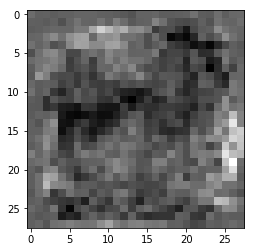

tf.Tensor(
[[  9.81397923 -13.58298735  -9.34677412 -16.22710385  -4.15097353
   -4.69298656 -11.54671628   6.27655744  -7.82295899  12.92369182]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[4.20005955e-02, 0.00000000e+00, 0.00000000e+00, 6.05450034e-01,
        1.57552019e-01, 2.57201795e-03, 4.88396361e-03, 1.18799247e-01,
        0.00000000e+00, 2.62058843e-02, 3.61075670e-01, 1.51777291e-03,
        0.00000000e+00, 9.64521337e-03, 1.29607171e-02, 9.27371442e-01,
        6.21126927e-02, 4.94792759e-01, 1.97449937e-01, 0.00000000e+00,
        4.26326925e-03, 9.88453507e-01, 0.00000000e+00, 9.97766137e-01,
        4.35616486e-02, 0.00000000e+00, 1.55078608e-03, 2.10804921e-02,
        3.77028622e-02, 9.41876292e-01, 3.06982249e-01, 3.06530129e-02,
        9.77692723e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.67205262e-01, 2.56512198e-04, 8.51412769e-03,
        8.39520097e-01, 8.22313488e-01,

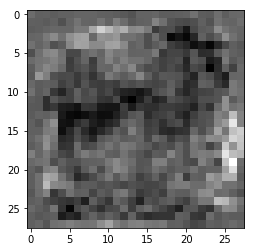

tf.Tensor(
[[  9.52540791 -13.80626004  -9.46465218 -16.05501218  -4.19577506
   -4.54768294 -11.99575842   6.271142    -7.90717251  13.2651168 ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[4.34251763e-02, 0.00000000e+00, 0.00000000e+00, 6.04111850e-01,
        1.58477098e-01, 3.25275492e-03, 5.66658052e-03, 1.18964277e-01,
        0.00000000e+00, 2.64052767e-02, 3.61820281e-01, 1.25001557e-03,
        0.00000000e+00, 8.74616392e-03, 1.22697689e-02, 9.27977085e-01,
        6.42603412e-02, 4.94797826e-01, 1.98798120e-01, 0.00000000e+00,
        4.47115116e-03, 9.87988114e-01, 0.00000000e+00, 9.97385085e-01,
        4.51285467e-02, 0.00000000e+00, 2.15344690e-03, 2.23712437e-02,
        3.89446355e-02, 9.40496564e-01, 3.05721551e-01, 3.11232302e-02,
        9.76893485e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.65012228e-01, 0.00000000e+00, 8.25705193e-03,
        8.37703228e-01, 8.19795728e-01,

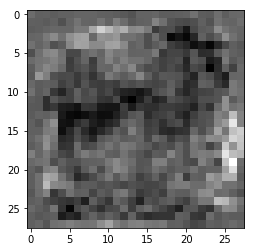

tf.Tensor(
[[  9.2123488  -13.96883219  -9.55689212 -15.88371549  -4.20563311
   -4.401319   -12.54280667   6.26800553  -8.0388504   13.64217079]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[4.47585732e-02, 0.00000000e+00, 0.00000000e+00, 6.02789700e-01,
        1.58845082e-01, 3.59629118e-03, 6.45393226e-03, 1.18696332e-01,
        0.00000000e+00, 2.66191177e-02, 3.62581223e-01, 1.03781896e-03,
        0.00000000e+00, 7.90857803e-03, 1.14500970e-02, 9.28510368e-01,
        6.59069493e-02, 4.95205402e-01, 1.99931771e-01, 0.00000000e+00,
        5.09593496e-03, 9.87643659e-01, 0.00000000e+00, 9.96733487e-01,
        4.67550084e-02, 0.00000000e+00, 2.42953561e-03, 2.35440247e-02,
        4.00139056e-02, 9.39358354e-01, 3.04871768e-01, 3.10403220e-02,
        9.76483345e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.64210665e-01, 0.00000000e+00, 8.64768587e-03,
        8.37225437e-01, 8.18861902e-01,

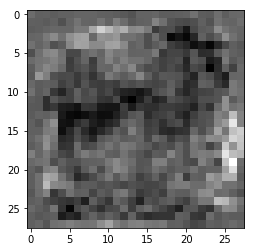

tf.Tensor(
[[  8.95646867 -14.18402261  -9.70855542 -15.74832705  -4.26024119
   -4.25680007 -13.03872715   6.27703356  -8.20495102  14.01747818]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[4.60917018e-02, 0.00000000e+00, 0.00000000e+00, 6.01467848e-01,
        1.59212992e-01, 3.93975899e-03, 7.24112615e-03, 1.18428439e-01,
        0.00000000e+00, 2.68329158e-02, 3.63342017e-01, 8.25664727e-04,
        0.00000000e+00, 7.07115978e-03, 1.06305890e-02, 9.29043531e-01,
        6.75532296e-02, 4.95612890e-01, 2.01065198e-01, 0.00000000e+00,
        5.72059397e-03, 9.87299263e-01, 0.00000000e+00, 9.96082067e-01,
        4.83811460e-02, 0.00000000e+00, 2.70556915e-03, 2.47165710e-02,
        4.10829633e-02, 9.38220382e-01, 3.04022163e-01, 3.09574287e-02,
        9.76073265e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.63409281e-01, 0.00000000e+00, 9.03824158e-03,
        8.36747706e-01, 8.17928255e-01,

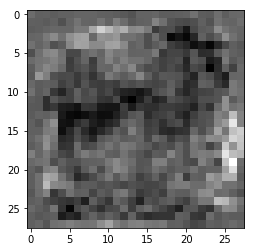

tf.Tensor(
[[  8.71190465 -14.42075085  -9.85368301 -15.61432436  -4.3027654
   -4.10345057 -13.52046558   6.27864748  -8.38030917  14.38363052]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[4.73454334e-02, 0.00000000e+00, 0.00000000e+00, 6.00144327e-01,
        1.59580693e-01, 4.26816707e-03, 8.04783218e-03, 1.18218094e-01,
        0.00000000e+00, 2.70109829e-02, 3.64104599e-01, 5.61115157e-04,
        0.00000000e+00, 6.27147872e-03, 9.87101346e-03, 9.29610610e-01,
        6.92140386e-02, 4.96064365e-01, 2.02149689e-01, 0.00000000e+00,
        6.29547751e-03, 9.86940801e-01, 0.00000000e+00, 9.95463014e-01,
        4.99096811e-02, 0.00000000e+00, 2.92450748e-03, 2.59528607e-02,
        4.21484075e-02, 9.37003434e-01, 3.03179860e-01, 3.08423266e-02,
        9.75661159e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.62644851e-01, 0.00000000e+00, 9.42331832e-03,
        8.36321294e-01, 8.17062855e-01, 

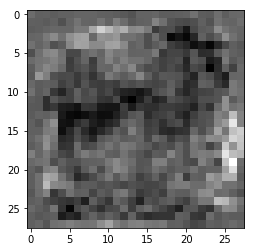

tf.Tensor(
[[  8.48530033 -14.66255793  -9.99569208 -15.48277363  -4.34844145
   -3.95781287 -13.9888671    6.28116151  -8.55555013  14.74251834]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[4.85989153e-02, 0.00000000e+00, 0.00000000e+00, 5.98821044e-01,
        1.59948319e-01, 4.59650904e-03, 8.85437708e-03, 1.18007787e-01,
        0.00000000e+00, 2.71890145e-02, 3.64867032e-01, 2.96618498e-04,
        0.00000000e+00, 5.47195785e-03, 9.11158975e-03, 9.30177569e-01,
        7.08745122e-02, 4.96515751e-01, 2.03233957e-01, 0.00000000e+00,
        6.87024603e-03, 9.86582458e-01, 0.00000000e+00, 9.94844079e-01,
        5.14379106e-02, 0.00000000e+00, 3.14340205e-03, 2.71889046e-02,
        4.32136394e-02, 9.35786724e-01, 3.02337736e-01, 3.07272468e-02,
        9.75249171e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.61880541e-01, 0.00000000e+00, 9.80831869e-03,
        8.35895002e-01, 8.16197634e-01,

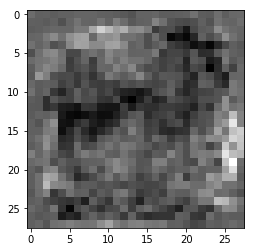

tf.Tensor(
[[  8.26350072 -14.90227423 -10.13615193 -15.34712894  -4.39838541
   -3.81573896 -14.45276492   6.28429885  -8.72969951  15.1019832 ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[4.97275367e-02, 0.00000000e+00, 0.00000000e+00, 5.97428203e-01,
        1.60232633e-01, 5.04217530e-03, 9.49939340e-03, 1.17807880e-01,
        0.00000000e+00, 2.72543672e-02, 3.65708858e-01, 0.00000000e+00,
        0.00000000e+00, 4.80756816e-03, 8.55196826e-03, 9.30812359e-01,
        7.26438165e-02, 4.96731251e-01, 2.04215765e-01, 0.00000000e+00,
        7.24706380e-03, 9.86235321e-01, 0.00000000e+00, 9.94202375e-01,
        5.28356172e-02, 0.00000000e+00, 3.21962195e-03, 2.84781177e-02,
        4.41950001e-02, 9.34424758e-01, 3.01646709e-01, 3.05755008e-02,
        9.75020170e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.61075759e-01, 0.00000000e+00, 1.00378832e-02,
        8.35445523e-01, 8.15520108e-01,

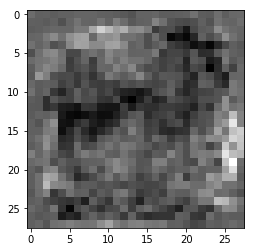

tf.Tensor(
[[  8.04779398 -15.14287649 -10.28358879 -15.19904914  -4.47222059
   -3.66142072 -14.92661847   6.29165571  -8.91126279  15.46806141]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[5.08559309e-02, 0.00000000e+00, 0.00000000e+00, 5.96035600e-01,
        1.60516888e-01, 5.48775261e-03, 1.01442812e-02, 1.17608011e-01,
        0.00000000e+00, 2.73197070e-02, 3.66550505e-01, 0.00000000e+00,
        0.00000000e+00, 4.14331118e-03, 7.99245853e-03, 9.31447029e-01,
        7.44127706e-02, 4.96946692e-01, 2.05197364e-01, 0.00000000e+00,
        7.62380613e-03, 9.85888302e-01, 0.00000000e+00, 9.93560851e-01,
        5.42330444e-02, 0.00000000e+00, 3.29582649e-03, 2.97670737e-02,
        4.51761633e-02, 9.33063090e-01, 3.00955832e-01, 3.04237846e-02,
        9.74791169e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.60271096e-01, 0.00000000e+00, 1.02674020e-02,
        8.34996104e-01, 8.14842701e-01,

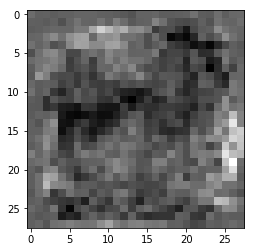

tf.Tensor(
[[  7.83225538 -15.37919495 -10.42706763 -15.05084265  -4.54310213
   -3.50804949 -15.39390301   6.2975783   -9.08912531  15.8289047 ]], shape=(1, 10), dtype=float64)
<tf.Variable 'Variable:0' shape=(1, 784) dtype=float32, numpy=
array([[5.19841015e-02, 0.00000000e+00, 0.00000000e+00, 5.94643295e-01,
        1.60801083e-01, 5.93324099e-03, 1.07890405e-02, 1.17408179e-01,
        0.00000000e+00, 2.73850337e-02, 3.67392004e-01, 0.00000000e+00,
        0.00000000e+00, 3.47918714e-03, 7.43306056e-03, 9.32081580e-01,
        7.61813670e-02, 4.97162104e-01, 2.06178769e-01, 0.00000000e+00,
        8.00047256e-03, 9.85541344e-01, 0.00000000e+00, 9.92919445e-01,
        5.56301922e-02, 0.00000000e+00, 3.37201590e-03, 3.10557708e-02,
        4.61571291e-02, 9.31701660e-01, 3.00265104e-01, 3.02721001e-02,
        9.74562228e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.59466612e-01, 0.00000000e+00, 1.04968753e-02,
        8.34546804e-01, 8.14165413e-01,

KeyboardInterrupt: 

In [125]:
lr = tf.constant([0.01], dtype='float64')
target = 9
lamb = tf.constant([0.01], dtype='float64')
iterations = 100
verbose = True
plot_image(activation_maximization(target = target, learning_rate = lr, lamb = lamb, iterations=iterations, verbose=verbose))








tf.Tensor(
[[  0.84924326  -2.79951984 -22.57692303 -33.61919295 -30.37384078
   -4.52168216  12.78305705  36.40360445 -35.9355004  -35.95893875]], shape=(1, 10), dtype=float64)
[-37.71006454]


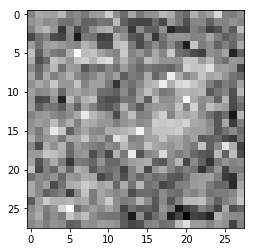

tf.Tensor(
[[-351.52579937  -21.99896866 -179.27802221 -195.98105319  368.7876474
  -182.86587173 -282.86004944   80.51650125 -259.75088907  -31.04127514]], shape=(1, 10), dtype=float64)
[354.14207123]


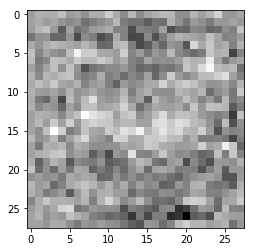

tf.Tensor(
[[-790.61566684 -130.70466166 -369.52901431 -622.54331235  958.26747931
  -257.87526006 -489.26606783  -16.7877785  -561.09871661 -236.21838365]], shape=(1, 10), dtype=float64)
[929.77470099]


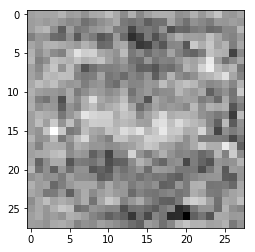

tf.Tensor(
[[-1268.53412788  -189.24567199  -596.20028205 -1038.8696306
   1534.79361379  -414.44286942  -791.29259243     7.39117959
   -950.19743634  -334.92030898]], shape=(1, 10), dtype=float64)
[1482.60645071]


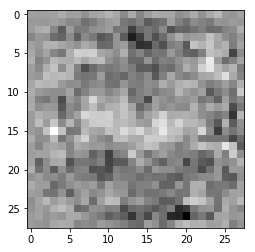

tf.Tensor(
[[-1.71224137e+03 -2.53493730e+02 -8.28393308e+02 -1.44878312e+03
   2.09514394e+03 -5.43381089e+02 -1.07381893e+03  1.41957511e+00
  -1.32464565e+03 -3.97312628e+02]], shape=(1, 10), dtype=float64)
[2009.00953529]


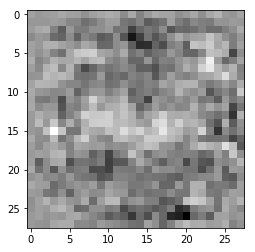

tf.Tensor(
[[-2147.71343337  -317.06080921 -1059.97378381 -1836.92478573
   2646.53638965  -679.30365298 -1348.61615115   -42.1424152
  -1677.36084407  -436.08977897]], shape=(1, 10), dtype=float64)
[2516.61152637]


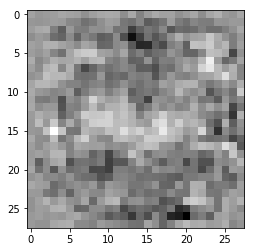

tf.Tensor(
[[-2571.78344305  -384.36705072 -1292.31998421 -2248.91646482
   3193.81259509  -792.66588874 -1589.44896001   -49.76370933
  -2038.19746732  -509.06132827]], shape=(1, 10), dtype=float64)
[3011.12257556]


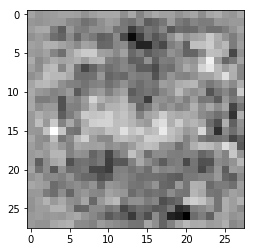

tf.Tensor(
[[-2985.56065575  -439.62366706 -1489.79265647 -2637.863376
   3719.41262193  -916.66574583 -1846.53184744   -54.25014164
  -2389.97255046  -575.95923176]], shape=(1, 10), dtype=float64)
[3475.37160631]


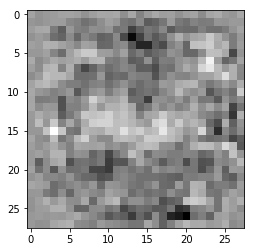

tf.Tensor(
[[-3381.48412105  -499.65037922 -1690.00248549 -3004.66366185
   4235.60042343 -1045.90828074 -2093.65335881  -106.58693448
  -2706.80039097  -629.26918344]], shape=(1, 10), dtype=float64)
[3922.17585311]


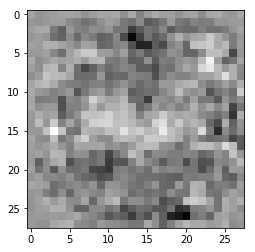

tf.Tensor(
[[-3785.29890922  -556.67769856 -1893.50581919 -3379.90620172
   4745.83298593 -1160.85705534 -2324.14241932  -102.34715874
  -3053.30511513  -709.55459479]], shape=(1, 10), dtype=float64)
[4355.75329843]


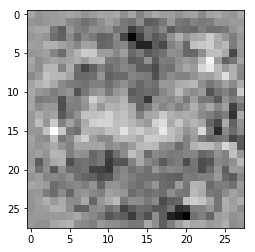

tf.Tensor(
[[-4164.13526367  -618.03982018 -2087.65105781 -3735.42967768
   5237.84464149 -1286.276526   -2565.38205241  -143.97933166
  -3353.41803909  -749.63500842]], shape=(1, 10), dtype=float64)
[4764.04229774]


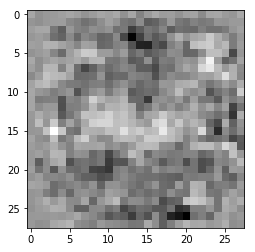

tf.Tensor(
[[-4557.70426822  -666.24528834 -2284.66760787 -4100.41232992
   5734.80912753 -1402.11003625 -2799.47008065  -144.0379815
  -3682.53997417  -823.19295448]], shape=(1, 10), dtype=float64)
[5171.08854159]


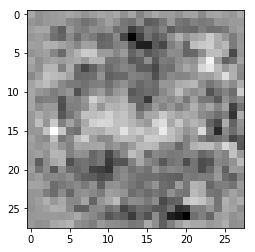

tf.Tensor(
[[-4922.59526825  -713.73907647 -2444.89469386 -4452.75673794
   6207.17175283 -1520.54765221 -3032.1140068   -148.48448092
  -4002.69357739  -884.8413599 ]], shape=(1, 10), dtype=float64)
[5547.40229971]


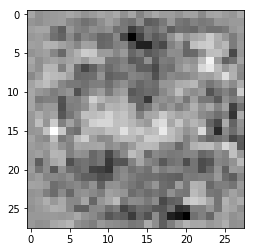

tf.Tensor(
[[-5293.97253855  -770.14396278 -2653.31829488 -4787.97120992
   6677.44640739 -1631.15298312 -3255.18288878  -178.98710509
  -4288.45093369  -935.4780851 ]], shape=(1, 10), dtype=float64)
[5916.12632926]


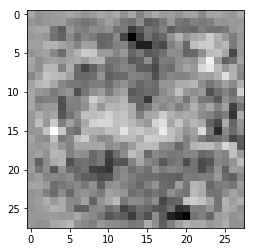

tf.Tensor(
[[-5643.32741279  -822.18960899 -2822.10982077 -5123.93497725
   7130.60354805 -1725.49099848 -3452.14459417  -173.36180591
  -4605.56607687 -1011.97501304]], shape=(1, 10), dtype=float64)
[6262.50729805]


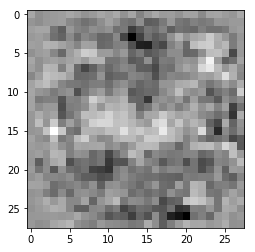

tf.Tensor(
[[-6004.13341338  -868.86191452 -3001.83855682 -5447.50923162
   7585.4939321  -1856.47974142 -3682.0559601   -213.16914162
  -4879.42315343 -1052.70155866]], shape=(1, 10), dtype=float64)
[6605.9558071]


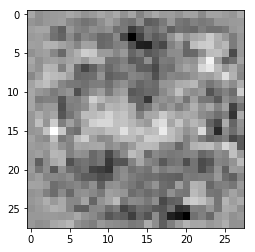

tf.Tensor(
[[-6342.41998173  -920.62393427 -3172.60020703 -5774.82711567
   8023.29087657 -1944.1873029  -3883.46637892  -203.93576549
  -5175.40398022 -1118.91366187]], shape=(1, 10), dtype=float64)
[6927.85079845]


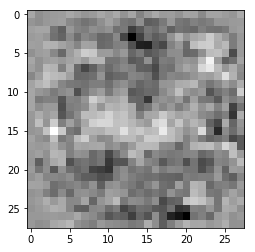

tf.Tensor(
[[-6688.11946306  -961.65400254 -3339.37925558 -6076.45661969
   8455.02027863 -2069.43206465 -4102.74568146  -241.69897412
  -5442.58432485 -1161.67417434]], shape=(1, 10), dtype=float64)
[7239.64105988]


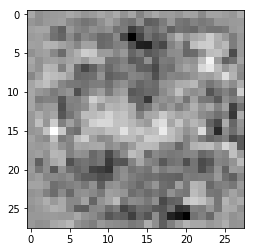

tf.Tensor(
[[-7011.32860287 -1013.19792461 -3505.90273119 -6397.57736505
   8879.51171265 -2157.48244381 -4281.74568482  -239.52584399
  -5729.23999691 -1227.80144926]], shape=(1, 10), dtype=float64)
[7540.51233765]


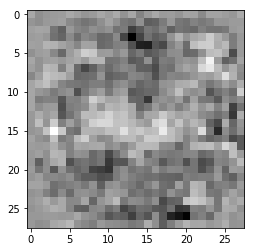

tf.Tensor(
[[-7339.61933813 -1058.77945253 -3667.82205346 -6689.05741127
   9291.3677229  -2272.56971759 -4493.21786804  -271.2826714
  -5981.26568603 -1266.23591064]], shape=(1, 10), dtype=float64)
[7825.2930354]


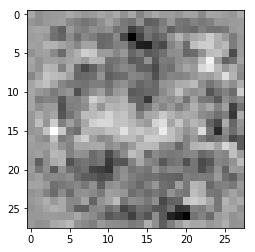

tf.Tensor(
[[-7656.17970445 -1108.30094296 -3832.97495606 -6995.07116815
   9701.62195077 -2358.27757042 -4669.71353663  -271.25057013
  -6256.93056834 -1331.22541414]], shape=(1, 10), dtype=float64)
[8105.47773202]


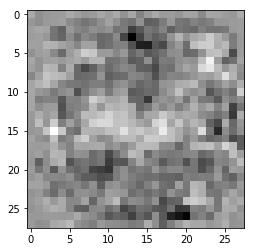

tf.Tensor(
[[-7955.53588843 -1149.45601817 -3961.91749721 -7288.26716601
  10095.95217271 -2451.62877535 -4859.09859176  -287.32971098
  -6521.45461029 -1387.8403111 ]], shape=(1, 10), dtype=float64)
[8366.82920396]


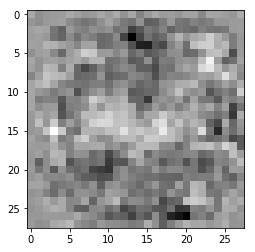

tf.Tensor(
[[-8266.63368109 -1192.69651197 -4123.93299425 -7562.49452553
  10486.43814502 -2557.99992557 -5059.54663055  -323.02550939
  -6756.77928812 -1419.29018765]], shape=(1, 10), dtype=float64)
[8621.84283252]


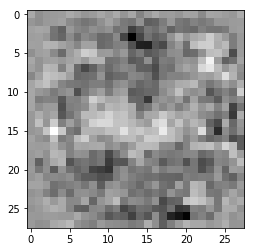

tf.Tensor(
[[-8569.40672839 -1235.19080409 -4278.01175615 -7849.58504269
  10871.82670262 -2640.78354641 -5229.94839223  -319.48217789
  -7023.14046541 -1478.83853094]], shape=(1, 10), dtype=float64)
[8869.50529637]


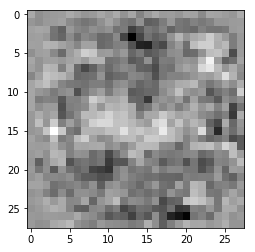

tf.Tensor(
[[-8857.1978005  -1274.25976727 -4418.84398046 -8116.8520324
  11242.96353385 -2743.95207937 -5417.53619624  -355.33892667
  -7250.62948821 -1509.76766823]], shape=(1, 10), dtype=float64)
[9100.78540885]


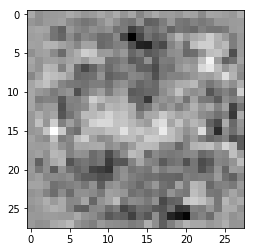

tf.Tensor(
[[-9154.68187787 -1314.99374015 -4575.94013876 -8392.9885119
  11617.3659686  -2822.44147415 -5595.22250765  -350.99926515
  -7498.05933794 -1562.10001415]], shape=(1, 10), dtype=float64)
[9333.65518735]


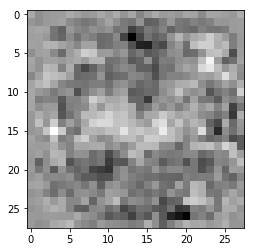

tf.Tensor(
[[-9429.65242141 -1347.98265983 -4692.42253984 -8659.76623499
  11972.72986401 -2912.76564998 -5771.43156708  -353.5101988
  -7741.82280796 -1609.01692429]], shape=(1, 10), dtype=float64)
[9545.78705151]


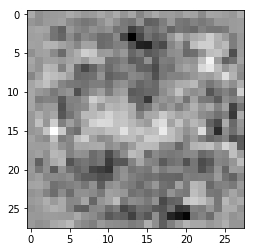

tf.Tensor(
[[-9706.30818424 -1393.42607363 -4855.85722729 -8915.32335717
  12328.33297801 -2994.76902794 -5926.13729884  -386.25705708
  -7957.58516769 -1647.43168121]], shape=(1, 10), dtype=float64)
[9756.80969676]


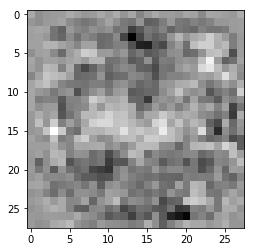

tf.Tensor(
[[-9979.85895705 -1427.85899029 -4976.9130023  -9171.87370362
  12674.48129969 -3082.57694748 -6102.38546973  -384.95710207
  -8191.48012386 -1691.45659348]], shape=(1, 10), dtype=float64)
[9957.18504969]


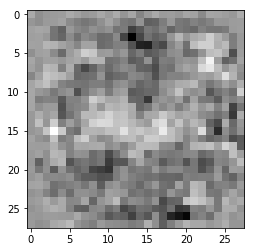

tf.Tensor(
[[-10241.26354431  -1466.45225385  -5125.16418814  -9413.3643109
   13011.21016893  -3159.47034592  -6260.21316893   -413.68366893
   -8396.98846174  -1726.13410675]], shape=(1, 10), dtype=float64)
[10147.08016893]


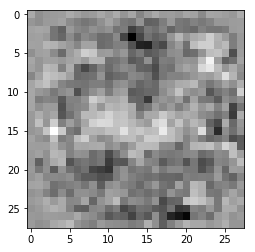

In [148]:
def plot_image(tensor): 
    pixels = am_input.numpy().reshape((28, 28))
    plt.figure(figsize=(4, 4))
    plt.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

def activation_maximization_loss(predictions, target, inp): 
    print(predictions)
    return tf.reduce_sum(tf.math.multiply(predictions, target)) - lamb * tf.reduce_mean(tf.cast(tf.square(tf.norm(inp)), dtype='double'))

    
am_input = tf.Variable(tf.random.normal((1, 784)), trainable=True)
target = tf.constant([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype='double')
learning_rate = tf.constant([1.0])
lamb = tf.constant([0.01], dtype='double')

iterations = 30
k = len(model.layers) - 1
for i in range(iterations):
    with tf.GradientTape() as tape:
        predictions = feed_through_k_layer(model, am_input, k)
        loss = activation_maximization_loss(predictions, target, am_input)
    print(loss.numpy())
    am_gradient = tape.gradient(loss, am_input) 
    #increase function so add gradient, may need to add learning rate
    am_input.assign_add(learning_rate * am_gradient)
    #am_input = tf.Variable(tf.clip_by_value(am_input, 0, 1), trainable=True)
    plot_image(am_input)